In [1]:
%matplotlib notebook

import pandas as pd
from fastkml import  kml
from matplotlib import pyplot as plt

In [159]:
# The wind farm data (140256 timestamps x 164 wind farms)
ercot_wind_power = pd.read_pickle("ercot_wind_power.pkl")

In [54]:
# get the locations for each of the wind farms
ercot_locations = {}
with open("rtmLmpPoints.kml", 'rt', encoding="utf-8") as ercot_location_file:
    doc = ercot_location_file.read()
    k = kml.KML()
    k.from_string(doc)
    features = list(k.features())
    for folder in features[0].features():
        for feat in folder.features():
            coords_plus_name = list(feat.geometry.coords[0])
            ercot_locations[feat.name] = coords_plus_name[:2]
    ercot_location_file.close()

# Add in coordinates of the locations not included or found in the provided KML file
ercot_locations['ASTRA_UNIT1'] = [-102.071477, 34.786654]
ercot_locations['KINGMTN_ALL'] = [-102.241490, 31.208996]

<IPython.core.display.Javascript object>


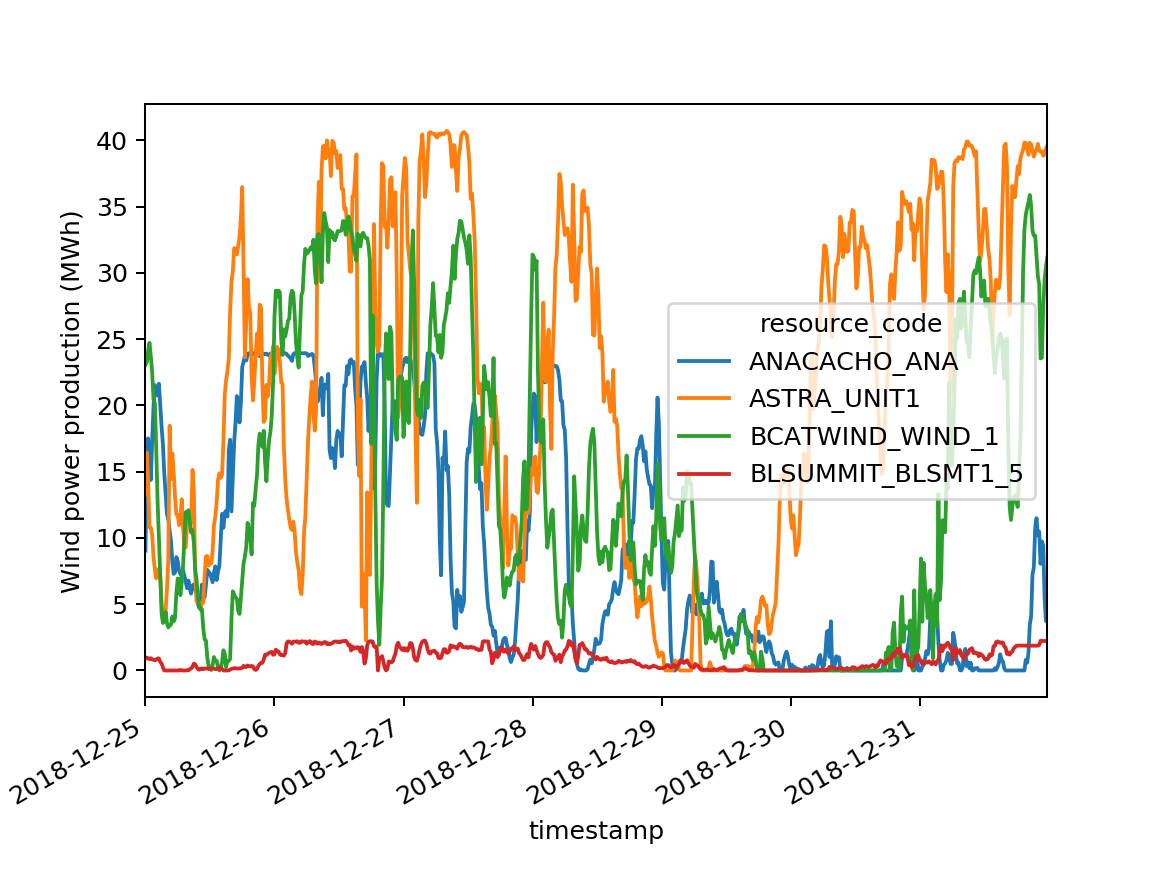

Text(0, 0.5, 'Wind power production (MWh)')

In [55]:
# Plot the last few days of wind farm output for 4 of the wind farms
ercot_wind_power.iloc[-168*4:,:4].plot()
plt.ylabel("Wind power production (MWh)")

In [56]:
# We are provided GPS coordinates of the wind farms, but the names provided are slightly different from the data
# We use a custom mapping to match the data with the coordinates

import csv

with open("data_name_to_coord_name.csv", mode='r') as infile:
    reader = csv.reader(infile)
    name_mapping = dict()
    name_mapping = {row[0]:row[1] for row in reader}
    infile.close()

data_name_to_coords = {key:ercot_locations[name_mapping[key]] for key in name_mapping}

# print(data_name_to_coords)

In [2]:
import numpy as np

# Locations corresponding to each of the NAM forecasts (140x140x2)
nam_locations = np.load("nam_locations.npy")

# Latitude and longitude are in the opposite order from the coordinate data for the wind farms
# This flips them so that everything is matching
nam_locations = nam_locations[:,:,::-1]

In [3]:
from os import path
import requests
import shutil

# The 32 shards of the NAM weather forecasting model output (24049x140x140x9)
# Each entry covers the entire 140x140 grid, indicating forecasted value
# for 9 weather variables in each time stamp
# The meaning of the 9 variables that NAM predicts:
# NAM_FIELDS = [
#     "accum_precip",
#     "dewpoint_temperature_2m",
#     "downward_short_wave_flux",
#     "relative_humidity_2m",
#     "sea_level_pressure",
#     "temperature_2m",
#     "total_cloud_cover",
#     "u_wind_80m",
#     "v_wind_80m",
# ]

all_nam_data = []
for i in range(32):
    data_file_name = "nam_data-000" + "{:02d}".format(i) + "-of-00032.npy"
    if not path.exists("nam_data/" + data_file_name):
        # Download the part file
        r = requests.get("http://storage.googleapis.com/gridmatic/roscoe/" + data_file_name, stream=True)
        with open("nam_data/" + data_file_name, 'wb') as fin:
            shutil.copyfileobj(r.raw, fin)
    all_nam_data.extend(np.load("nam_data/" + data_file_name))

In [4]:
# A one-dimensional list of the timestamps for the NAM inputs (24049x1)
# The dimension is the number of 1 HOUR INTERVALS in the time period
# TODO make NAM's hourly data work with ERCOT's 15-minute data
nam_timestamps = pd.read_pickle("nam_timestamps.pkl")

In [5]:
# print(len(nam_timestamps))
from pprint import pprint

pprint(len(nam_timestamps))
# pprint(len(all_nam_data))
# print()
# print(ercot_wind_power.iloc[:10,:3])
print(nam_timestamps[5])

24049
2015-01-01 05:00:00-06:00


In [6]:
# NEW APPROACH: NAM has a lot of dates missing. This attempts to generate new NAM data so that they match up
# It will just generate hourly data that is missing. Which should be alright for the regular 3-hour jumps
# but dealing with the entire days that are missing will be tough

# Function to generate new data
# QUESTION: will this insert at generating time?
# Should I manually track index and increment it for each generated value?
# I'll start with that
  
def resampling_function(something):
    pprint('ARNAV')
    pprint(something)


In [7]:
# Create a Pandas dataframe of the timestamps
nam_df = pd.DataFrame({'timestamps': nam_timestamps, 'data_objects': all_nam_data});
# # pprint();
nam_df = nam_df.set_index('timestamps');
pprint(nam_df[:24])

                                                                data_objects
timestamps                                                                  
2015-01-01 00:00:00-06:00  [[[0.0, 290.68085, 0.0, 74.0, 101553.0, 295.79...
2015-01-01 01:00:00-06:00  [[[0.0, 290.43628, 0.0, 73.0, 101516.0, 295.77...
2015-01-01 02:00:00-06:00  [[[0.0, 290.8083, 0.0, 74.0, 101502.0, 295.740...
2015-01-01 03:00:00-06:00  [[[0.0, 290.99026, 0.0, 75.0, 101467.0, 295.66...
2015-01-01 04:00:00-06:00  [[[0.0, 290.83884, 0.0, 75.0, 101436.0, 295.67...
2015-01-01 05:00:00-06:00  [[[0.0, 290.83582, 0.0, 75.0, 101412.0, 295.64...
2015-01-01 06:00:00-06:00  [[[0.0, 290.7572, 0.0, 75.0, 101402.0, 295.582...
2015-01-01 07:00:00-06:00  [[[0.0, 290.68234, 0.0, 74.0, 101416.0, 295.55...
2015-01-01 08:00:00-06:00  [[[0.0, 290.57135, 4.125, 74.0, 101457.0, 295....
2015-01-01 09:00:00-06:00  [[[0.0, 290.63098, 106.0, 75.0, 101469.0, 295....
2015-01-01 10:00:00-06:00  [[[0.0, 290.9336, 329.25, 77.0, 101512.0, 295....

In [117]:
# WORKING SOLUTION WITH PADDING:
# nam_padded_df = nam_df.resample('H').pad();
# (Trying to do linear interpolation so hopefully this can be ignored after that's done)
# (But in case that doesn't happen, backup is this)

nam_unfilled_df = nam_df.resample('H').asfreq();

pprint(nam_unfilled_df[:48]);

                                                                data_objects
timestamps                                                                  
2015-01-01 00:00:00-06:00  [[[0.0, 290.68085, 0.0, 74.0, 101553.0, 295.79...
2015-01-01 01:00:00-06:00  [[[0.0, 290.43628, 0.0, 73.0, 101516.0, 295.77...
2015-01-01 02:00:00-06:00  [[[0.0, 290.8083, 0.0, 74.0, 101502.0, 295.740...
2015-01-01 03:00:00-06:00  [[[0.0, 290.99026, 0.0, 75.0, 101467.0, 295.66...
2015-01-01 04:00:00-06:00  [[[0.0, 290.83884, 0.0, 75.0, 101436.0, 295.67...
2015-01-01 05:00:00-06:00  [[[0.0, 290.83582, 0.0, 75.0, 101412.0, 295.64...
2015-01-01 06:00:00-06:00  [[[0.0, 290.7572, 0.0, 75.0, 101402.0, 295.582...
2015-01-01 07:00:00-06:00  [[[0.0, 290.68234, 0.0, 74.0, 101416.0, 295.55...
2015-01-01 08:00:00-06:00  [[[0.0, 290.57135, 4.125, 74.0, 101457.0, 295....
2015-01-01 09:00:00-06:00  [[[0.0, 290.63098, 106.0, 75.0, 101469.0, 295....
2015-01-01 10:00:00-06:00  [[[0.0, 290.9336, 329.25, 77.0, 101512.0, 295....

In [132]:
# x = nam_unfilled_df.isnull().reset_index('timestamps')
# truth = x.groupby('data_objects').apply(np.array)
# pprint(truth.iloc[1])

def random_func(array_thing):
    print(type(array_thing.iloc[0]))

# nam_unfilled_df.resample('H').apply(random_func)
# pprint(nam_unfilled_df.index[:24])
# pprint(nam_unfilled_df[:24])
print(isinstance(nam_unfilled_df.iloc[0][0], np.ndarray))

True


In [157]:
import math
def find_closest_value(adj_time, direction):
    i = 0
    adj_value = nam_unfilled_df.iloc[nam_unfilled_df.index.get_loc(adj_time)].iloc[0]
    while (type(adj_value) is float and math.isnan(adj_value)):
#         print(math.isnan(adj_value))
        
#         print('arnav')
#         print(adj_time)
#         print(f'ARNAV {nam_unfilled_df.iloc[nam_unfilled_df.index.get_loc(adj_time, method="nearest")]}')
        i += 1
#         print(i)
        adj_time += direction * pd.Timedelta(hours=1)        
        adj_value = nam_unfilled_df.iloc[nam_unfilled_df.index.get_loc(adj_time)].iloc[0]
        
#         adj_value = nam_unfilled_df.loc[adj_time].iloc[0]['data_objects']
#         print('ARNAV ' + str(adj_value.iloc[0]))
#         print(str(type(adj_value is not float))
#         print(str(math.isnan(adj_value.iloc[0]['data_objects'])))
#         print(str(math.isnan(adj_value)))
    return (adj_value,i)

def generate_new_value(timestamp):
#     print(f'entered generate for {timestamp}')
#     timestamp = timestamp.index[0]
#     loc = nam_unfilled_df.index.get_loc(timestamp, method="nearest")
#     print(f'The location of {timestamp} is {loc}')
#     if timestamp not in nam_unfilled_df.index:
#         print(f'ARNAV {timestamp} NOT found in index')
#     return None
    prev_value, prev_dist = find_closest_value(timestamp, -1)
#     print(f'found a real value {prev_dist} hours before {timestamp}')
    next_value, next_dist = find_closest_value(timestamp, 1)
#     print(f'found a real value {next_dist} hours after {timestamp}')
#     return None
    percentage = 1 if (prev_dist + next_dist) == 0 else prev_dist / (prev_dist + next_dist)
#     print(f'percentage is {percentage}')

    return np.add(prev_value, (np.subtract(next_value, prev_value) * percentage))
    

def fill_in_missing_time(slice_of_df):
#     print(str(type(slice_of_df.loc[Name])))
#     print(str(type(slice_of_df.name)))
    value = slice_of_df.iloc[0]
#     print(f'arnav {str(type(value))}')
#     if type(value) is float and math.isnan(value):
#     if True:
#         pprint(str(type(slice_of_df.index[0])))
    timestamp = slice_of_df.name
    timestamp = pd.Timestamp(timestamp) if isinstance(timestamp, np.datetime64) else timestamp
    print(timestamp)
#         loc = nam_unfilled_df.index.get_loc(timestamp, method="nearest")
#         print(f'The location of {timestamp} is {loc}')
#         timestamp = slice_of_df.index.to_series()

#         timestamp = timestamp.tz_localize('UTC').tz_convert('US/Central')
#         timestamp = timestamp.tz_localize('US/Central')

    # Don't want to generate a new value if we've done so for this timestamp already
#     if isinstance(value, tuple):
#         return slice_of_df

    new_val = generate_new_value(timestamp)
#         new_val = (new_val,)
#         new_val = 42
#         print(str(type(new_val)))
#     slice_of_df.iloc[0] = (new_val,) if not isinstance(value, tuple) else value
    slice_of_df.iloc[0] = new_val
    return slice_of_df


#     else:
#         slice_of_df.iloc[0] = value
#         return slice_of_df


nam_interpolated_df = []
# Perform linear interpolation
# nam_interpolated_df = nam_unfilled_df.resample('H').apply(fill_in_missing_time)
nam_interpolated_df = nam_unfilled_df.apply(fill_in_missing_time, axis=1)

# pprint(nam_unfilled_df.index[:24]);

pprint(nam_interpolated_df[:24])

2015-01-01 06:00:00
2015-01-01 00:00:00-06:00
2015-01-01 01:00:00-06:00
2015-01-01 02:00:00-06:00
2015-01-01 03:00:00-06:00
2015-01-01 04:00:00-06:00
2015-01-01 05:00:00-06:00
2015-01-01 06:00:00-06:00
2015-01-01 07:00:00-06:00
2015-01-01 08:00:00-06:00
2015-01-01 09:00:00-06:00
2015-01-01 10:00:00-06:00
2015-01-01 11:00:00-06:00
2015-01-01 12:00:00-06:00
2015-01-01 13:00:00-06:00
2015-01-01 14:00:00-06:00
2015-01-01 15:00:00-06:00
2015-01-01 16:00:00-06:00
2015-01-01 17:00:00-06:00
2015-01-01 18:00:00-06:00
2015-01-01 19:00:00-06:00
2015-01-01 20:00:00-06:00
2015-01-01 21:00:00-06:00
2015-01-01 22:00:00-06:00
2015-01-01 23:00:00-06:00
2015-01-02 00:00:00-06:00
2015-01-02 01:00:00-06:00
2015-01-02 02:00:00-06:00
2015-01-02 03:00:00-06:00
2015-01-02 04:00:00-06:00
2015-01-02 05:00:00-06:00
2015-01-02 06:00:00-06:00
2015-01-02 07:00:00-06:00
2015-01-02 08:00:00-06:00
2015-01-02 09:00:00-06:00
2015-01-02 10:00:00-06:00
2015-01-02 11:00:00-06:00
2015-01-02 12:00:00-06:00
2015-01-02 13:00:0

2015-01-14 18:00:00-06:00
2015-01-14 19:00:00-06:00
2015-01-14 20:00:00-06:00
2015-01-14 21:00:00-06:00
2015-01-14 22:00:00-06:00
2015-01-14 23:00:00-06:00
2015-01-15 00:00:00-06:00
2015-01-15 01:00:00-06:00
2015-01-15 02:00:00-06:00
2015-01-15 03:00:00-06:00
2015-01-15 04:00:00-06:00
2015-01-15 05:00:00-06:00
2015-01-15 06:00:00-06:00
2015-01-15 07:00:00-06:00
2015-01-15 08:00:00-06:00
2015-01-15 09:00:00-06:00
2015-01-15 10:00:00-06:00
2015-01-15 11:00:00-06:00
2015-01-15 12:00:00-06:00
2015-01-15 13:00:00-06:00
2015-01-15 14:00:00-06:00
2015-01-15 15:00:00-06:00
2015-01-15 16:00:00-06:00
2015-01-15 17:00:00-06:00
2015-01-15 18:00:00-06:00
2015-01-15 19:00:00-06:00
2015-01-15 20:00:00-06:00
2015-01-15 21:00:00-06:00
2015-01-15 22:00:00-06:00
2015-01-15 23:00:00-06:00
2015-01-16 00:00:00-06:00
2015-01-16 01:00:00-06:00
2015-01-16 02:00:00-06:00
2015-01-16 03:00:00-06:00
2015-01-16 04:00:00-06:00
2015-01-16 05:00:00-06:00
2015-01-16 06:00:00-06:00
2015-01-16 07:00:00-06:00
2015-01-16 0

2015-01-27 22:00:00-06:00
2015-01-27 23:00:00-06:00
2015-01-28 00:00:00-06:00
2015-01-28 01:00:00-06:00
2015-01-28 02:00:00-06:00
2015-01-28 03:00:00-06:00
2015-01-28 04:00:00-06:00
2015-01-28 05:00:00-06:00
2015-01-28 06:00:00-06:00
2015-01-28 07:00:00-06:00
2015-01-28 08:00:00-06:00
2015-01-28 09:00:00-06:00
2015-01-28 10:00:00-06:00
2015-01-28 11:00:00-06:00
2015-01-28 12:00:00-06:00
2015-01-28 13:00:00-06:00
2015-01-28 14:00:00-06:00
2015-01-28 15:00:00-06:00
2015-01-28 16:00:00-06:00
2015-01-28 17:00:00-06:00
2015-01-28 18:00:00-06:00
2015-01-28 19:00:00-06:00
2015-01-28 20:00:00-06:00
2015-01-28 21:00:00-06:00
2015-01-28 22:00:00-06:00
2015-01-28 23:00:00-06:00
2015-01-29 00:00:00-06:00
2015-01-29 01:00:00-06:00
2015-01-29 02:00:00-06:00
2015-01-29 03:00:00-06:00
2015-01-29 04:00:00-06:00
2015-01-29 05:00:00-06:00
2015-01-29 06:00:00-06:00
2015-01-29 07:00:00-06:00
2015-01-29 08:00:00-06:00
2015-01-29 09:00:00-06:00
2015-01-29 10:00:00-06:00
2015-01-29 11:00:00-06:00
2015-01-29 1

2015-02-10 23:00:00-06:00
2015-02-11 00:00:00-06:00
2015-02-11 01:00:00-06:00
2015-02-11 02:00:00-06:00
2015-02-11 03:00:00-06:00
2015-02-11 04:00:00-06:00
2015-02-11 05:00:00-06:00
2015-02-11 06:00:00-06:00
2015-02-11 07:00:00-06:00
2015-02-11 08:00:00-06:00
2015-02-11 09:00:00-06:00
2015-02-11 10:00:00-06:00
2015-02-11 11:00:00-06:00
2015-02-11 12:00:00-06:00
2015-02-11 13:00:00-06:00
2015-02-11 14:00:00-06:00
2015-02-11 15:00:00-06:00
2015-02-11 16:00:00-06:00
2015-02-11 17:00:00-06:00
2015-02-11 18:00:00-06:00
2015-02-11 19:00:00-06:00
2015-02-11 20:00:00-06:00
2015-02-11 21:00:00-06:00
2015-02-11 22:00:00-06:00
2015-02-11 23:00:00-06:00
2015-02-12 00:00:00-06:00
2015-02-12 01:00:00-06:00
2015-02-12 02:00:00-06:00
2015-02-12 03:00:00-06:00
2015-02-12 04:00:00-06:00
2015-02-12 05:00:00-06:00
2015-02-12 06:00:00-06:00
2015-02-12 07:00:00-06:00
2015-02-12 08:00:00-06:00
2015-02-12 09:00:00-06:00
2015-02-12 10:00:00-06:00
2015-02-12 11:00:00-06:00
2015-02-12 12:00:00-06:00
2015-02-12 1

2015-02-25 05:00:00-06:00
2015-02-25 06:00:00-06:00
2015-02-25 07:00:00-06:00
2015-02-25 08:00:00-06:00
2015-02-25 09:00:00-06:00
2015-02-25 10:00:00-06:00
2015-02-25 11:00:00-06:00
2015-02-25 12:00:00-06:00
2015-02-25 13:00:00-06:00
2015-02-25 14:00:00-06:00
2015-02-25 15:00:00-06:00
2015-02-25 16:00:00-06:00
2015-02-25 17:00:00-06:00
2015-02-25 18:00:00-06:00
2015-02-25 19:00:00-06:00
2015-02-25 20:00:00-06:00
2015-02-25 21:00:00-06:00
2015-02-25 22:00:00-06:00
2015-02-25 23:00:00-06:00
2015-02-26 00:00:00-06:00
2015-02-26 01:00:00-06:00
2015-02-26 02:00:00-06:00
2015-02-26 03:00:00-06:00
2015-02-26 04:00:00-06:00
2015-02-26 05:00:00-06:00
2015-02-26 06:00:00-06:00
2015-02-26 07:00:00-06:00
2015-02-26 08:00:00-06:00
2015-02-26 09:00:00-06:00
2015-02-26 10:00:00-06:00
2015-02-26 11:00:00-06:00
2015-02-26 12:00:00-06:00
2015-02-26 13:00:00-06:00
2015-02-26 14:00:00-06:00
2015-02-26 15:00:00-06:00
2015-02-26 16:00:00-06:00
2015-02-26 17:00:00-06:00
2015-02-26 18:00:00-06:00
2015-02-26 1

2015-03-10 11:00:00-05:00
2015-03-10 12:00:00-05:00
2015-03-10 13:00:00-05:00
2015-03-10 14:00:00-05:00
2015-03-10 15:00:00-05:00
2015-03-10 16:00:00-05:00
2015-03-10 17:00:00-05:00
2015-03-10 18:00:00-05:00
2015-03-10 19:00:00-05:00
2015-03-10 20:00:00-05:00
2015-03-10 21:00:00-05:00
2015-03-10 22:00:00-05:00
2015-03-10 23:00:00-05:00
2015-03-11 00:00:00-05:00
2015-03-11 01:00:00-05:00
2015-03-11 02:00:00-05:00
2015-03-11 03:00:00-05:00
2015-03-11 04:00:00-05:00
2015-03-11 05:00:00-05:00
2015-03-11 06:00:00-05:00
2015-03-11 07:00:00-05:00
2015-03-11 08:00:00-05:00
2015-03-11 09:00:00-05:00
2015-03-11 10:00:00-05:00
2015-03-11 11:00:00-05:00
2015-03-11 12:00:00-05:00
2015-03-11 13:00:00-05:00
2015-03-11 14:00:00-05:00
2015-03-11 15:00:00-05:00
2015-03-11 16:00:00-05:00
2015-03-11 17:00:00-05:00
2015-03-11 18:00:00-05:00
2015-03-11 19:00:00-05:00
2015-03-11 20:00:00-05:00
2015-03-11 21:00:00-05:00
2015-03-11 22:00:00-05:00
2015-03-11 23:00:00-05:00
2015-03-12 00:00:00-05:00
2015-03-12 0

2015-03-24 14:00:00-05:00
2015-03-24 15:00:00-05:00
2015-03-24 16:00:00-05:00
2015-03-24 17:00:00-05:00
2015-03-24 18:00:00-05:00
2015-03-24 19:00:00-05:00
2015-03-24 20:00:00-05:00
2015-03-24 21:00:00-05:00
2015-03-24 22:00:00-05:00
2015-03-24 23:00:00-05:00
2015-03-25 00:00:00-05:00
2015-03-25 01:00:00-05:00
2015-03-25 02:00:00-05:00
2015-03-25 03:00:00-05:00
2015-03-25 04:00:00-05:00
2015-03-25 05:00:00-05:00
2015-03-25 06:00:00-05:00
2015-03-25 07:00:00-05:00
2015-03-25 08:00:00-05:00
2015-03-25 09:00:00-05:00
2015-03-25 10:00:00-05:00
2015-03-25 11:00:00-05:00
2015-03-25 12:00:00-05:00
2015-03-25 13:00:00-05:00
2015-03-25 14:00:00-05:00
2015-03-25 15:00:00-05:00
2015-03-25 16:00:00-05:00
2015-03-25 17:00:00-05:00
2015-03-25 18:00:00-05:00
2015-03-25 19:00:00-05:00
2015-03-25 20:00:00-05:00
2015-03-25 21:00:00-05:00
2015-03-25 22:00:00-05:00
2015-03-25 23:00:00-05:00
2015-03-26 00:00:00-05:00
2015-03-26 01:00:00-05:00
2015-03-26 02:00:00-05:00
2015-03-26 03:00:00-05:00
2015-03-26 0

2015-04-07 19:00:00-05:00
2015-04-07 20:00:00-05:00
2015-04-07 21:00:00-05:00
2015-04-07 22:00:00-05:00
2015-04-07 23:00:00-05:00
2015-04-08 00:00:00-05:00
2015-04-08 01:00:00-05:00
2015-04-08 02:00:00-05:00
2015-04-08 03:00:00-05:00
2015-04-08 04:00:00-05:00
2015-04-08 05:00:00-05:00
2015-04-08 06:00:00-05:00
2015-04-08 07:00:00-05:00
2015-04-08 08:00:00-05:00
2015-04-08 09:00:00-05:00
2015-04-08 10:00:00-05:00
2015-04-08 11:00:00-05:00
2015-04-08 12:00:00-05:00
2015-04-08 13:00:00-05:00
2015-04-08 14:00:00-05:00
2015-04-08 15:00:00-05:00
2015-04-08 16:00:00-05:00
2015-04-08 17:00:00-05:00
2015-04-08 18:00:00-05:00
2015-04-08 19:00:00-05:00
2015-04-08 20:00:00-05:00
2015-04-08 21:00:00-05:00
2015-04-08 22:00:00-05:00
2015-04-08 23:00:00-05:00
2015-04-09 00:00:00-05:00
2015-04-09 01:00:00-05:00
2015-04-09 02:00:00-05:00
2015-04-09 03:00:00-05:00
2015-04-09 04:00:00-05:00
2015-04-09 05:00:00-05:00
2015-04-09 06:00:00-05:00
2015-04-09 07:00:00-05:00
2015-04-09 08:00:00-05:00
2015-04-09 0

2015-04-21 16:00:00-05:00
2015-04-21 17:00:00-05:00
2015-04-21 18:00:00-05:00
2015-04-21 19:00:00-05:00
2015-04-21 20:00:00-05:00
2015-04-21 21:00:00-05:00
2015-04-21 22:00:00-05:00
2015-04-21 23:00:00-05:00
2015-04-22 00:00:00-05:00
2015-04-22 01:00:00-05:00
2015-04-22 02:00:00-05:00
2015-04-22 03:00:00-05:00
2015-04-22 04:00:00-05:00
2015-04-22 05:00:00-05:00
2015-04-22 06:00:00-05:00
2015-04-22 07:00:00-05:00
2015-04-22 08:00:00-05:00
2015-04-22 09:00:00-05:00
2015-04-22 10:00:00-05:00
2015-04-22 11:00:00-05:00
2015-04-22 12:00:00-05:00
2015-04-22 13:00:00-05:00
2015-04-22 14:00:00-05:00
2015-04-22 15:00:00-05:00
2015-04-22 16:00:00-05:00
2015-04-22 17:00:00-05:00
2015-04-22 18:00:00-05:00
2015-04-22 19:00:00-05:00
2015-04-22 20:00:00-05:00
2015-04-22 21:00:00-05:00
2015-04-22 22:00:00-05:00
2015-04-22 23:00:00-05:00
2015-04-23 00:00:00-05:00
2015-04-23 01:00:00-05:00
2015-04-23 02:00:00-05:00
2015-04-23 03:00:00-05:00
2015-04-23 04:00:00-05:00
2015-04-23 05:00:00-05:00
2015-04-23 0

2015-05-05 14:00:00-05:00
2015-05-05 15:00:00-05:00
2015-05-05 16:00:00-05:00
2015-05-05 17:00:00-05:00
2015-05-05 18:00:00-05:00
2015-05-05 19:00:00-05:00
2015-05-05 20:00:00-05:00
2015-05-05 21:00:00-05:00
2015-05-05 22:00:00-05:00
2015-05-05 23:00:00-05:00
2015-05-06 00:00:00-05:00
2015-05-06 01:00:00-05:00
2015-05-06 02:00:00-05:00
2015-05-06 03:00:00-05:00
2015-05-06 04:00:00-05:00
2015-05-06 05:00:00-05:00
2015-05-06 06:00:00-05:00
2015-05-06 07:00:00-05:00
2015-05-06 08:00:00-05:00
2015-05-06 09:00:00-05:00
2015-05-06 10:00:00-05:00
2015-05-06 11:00:00-05:00
2015-05-06 12:00:00-05:00
2015-05-06 13:00:00-05:00
2015-05-06 14:00:00-05:00
2015-05-06 15:00:00-05:00
2015-05-06 16:00:00-05:00
2015-05-06 17:00:00-05:00
2015-05-06 18:00:00-05:00
2015-05-06 19:00:00-05:00
2015-05-06 20:00:00-05:00
2015-05-06 21:00:00-05:00
2015-05-06 22:00:00-05:00
2015-05-06 23:00:00-05:00
2015-05-07 00:00:00-05:00
2015-05-07 01:00:00-05:00
2015-05-07 02:00:00-05:00
2015-05-07 03:00:00-05:00
2015-05-07 0

2015-05-19 05:00:00-05:00
2015-05-19 06:00:00-05:00
2015-05-19 07:00:00-05:00
2015-05-19 08:00:00-05:00
2015-05-19 09:00:00-05:00
2015-05-19 10:00:00-05:00
2015-05-19 11:00:00-05:00
2015-05-19 12:00:00-05:00
2015-05-19 13:00:00-05:00
2015-05-19 14:00:00-05:00
2015-05-19 15:00:00-05:00
2015-05-19 16:00:00-05:00
2015-05-19 17:00:00-05:00
2015-05-19 18:00:00-05:00
2015-05-19 19:00:00-05:00
2015-05-19 20:00:00-05:00
2015-05-19 21:00:00-05:00
2015-05-19 22:00:00-05:00
2015-05-19 23:00:00-05:00
2015-05-20 00:00:00-05:00
2015-05-20 01:00:00-05:00
2015-05-20 02:00:00-05:00
2015-05-20 03:00:00-05:00
2015-05-20 04:00:00-05:00
2015-05-20 05:00:00-05:00
2015-05-20 06:00:00-05:00
2015-05-20 07:00:00-05:00
2015-05-20 08:00:00-05:00
2015-05-20 09:00:00-05:00
2015-05-20 10:00:00-05:00
2015-05-20 11:00:00-05:00
2015-05-20 12:00:00-05:00
2015-05-20 13:00:00-05:00
2015-05-20 14:00:00-05:00
2015-05-20 15:00:00-05:00
2015-05-20 16:00:00-05:00
2015-05-20 17:00:00-05:00
2015-05-20 18:00:00-05:00
2015-05-20 1

2015-06-02 09:00:00-05:00
2015-06-02 10:00:00-05:00
2015-06-02 11:00:00-05:00
2015-06-02 12:00:00-05:00
2015-06-02 13:00:00-05:00
2015-06-02 14:00:00-05:00
2015-06-02 15:00:00-05:00
2015-06-02 16:00:00-05:00
2015-06-02 17:00:00-05:00
2015-06-02 18:00:00-05:00
2015-06-02 19:00:00-05:00
2015-06-02 20:00:00-05:00
2015-06-02 21:00:00-05:00
2015-06-02 22:00:00-05:00
2015-06-02 23:00:00-05:00
2015-06-03 00:00:00-05:00
2015-06-03 01:00:00-05:00
2015-06-03 02:00:00-05:00
2015-06-03 03:00:00-05:00
2015-06-03 04:00:00-05:00
2015-06-03 05:00:00-05:00
2015-06-03 06:00:00-05:00
2015-06-03 07:00:00-05:00
2015-06-03 08:00:00-05:00
2015-06-03 09:00:00-05:00
2015-06-03 10:00:00-05:00
2015-06-03 11:00:00-05:00
2015-06-03 12:00:00-05:00
2015-06-03 13:00:00-05:00
2015-06-03 14:00:00-05:00
2015-06-03 15:00:00-05:00
2015-06-03 16:00:00-05:00
2015-06-03 17:00:00-05:00
2015-06-03 18:00:00-05:00
2015-06-03 19:00:00-05:00
2015-06-03 20:00:00-05:00
2015-06-03 21:00:00-05:00
2015-06-03 22:00:00-05:00
2015-06-03 2

2015-06-16 09:00:00-05:00
2015-06-16 10:00:00-05:00
2015-06-16 11:00:00-05:00
2015-06-16 12:00:00-05:00
2015-06-16 13:00:00-05:00
2015-06-16 14:00:00-05:00
2015-06-16 15:00:00-05:00
2015-06-16 16:00:00-05:00
2015-06-16 17:00:00-05:00
2015-06-16 18:00:00-05:00
2015-06-16 19:00:00-05:00
2015-06-16 20:00:00-05:00
2015-06-16 21:00:00-05:00
2015-06-16 22:00:00-05:00
2015-06-16 23:00:00-05:00
2015-06-17 00:00:00-05:00
2015-06-17 01:00:00-05:00
2015-06-17 02:00:00-05:00
2015-06-17 03:00:00-05:00
2015-06-17 04:00:00-05:00
2015-06-17 05:00:00-05:00
2015-06-17 06:00:00-05:00
2015-06-17 07:00:00-05:00
2015-06-17 08:00:00-05:00
2015-06-17 09:00:00-05:00
2015-06-17 10:00:00-05:00
2015-06-17 11:00:00-05:00
2015-06-17 12:00:00-05:00
2015-06-17 13:00:00-05:00
2015-06-17 14:00:00-05:00
2015-06-17 15:00:00-05:00
2015-06-17 16:00:00-05:00
2015-06-17 17:00:00-05:00
2015-06-17 18:00:00-05:00
2015-06-17 19:00:00-05:00
2015-06-17 20:00:00-05:00
2015-06-17 21:00:00-05:00
2015-06-17 22:00:00-05:00
2015-06-17 2

2015-06-29 14:00:00-05:00
2015-06-29 15:00:00-05:00
2015-06-29 16:00:00-05:00
2015-06-29 17:00:00-05:00
2015-06-29 18:00:00-05:00
2015-06-29 19:00:00-05:00
2015-06-29 20:00:00-05:00
2015-06-29 21:00:00-05:00
2015-06-29 22:00:00-05:00
2015-06-29 23:00:00-05:00
2015-06-30 00:00:00-05:00
2015-06-30 01:00:00-05:00
2015-06-30 02:00:00-05:00
2015-06-30 03:00:00-05:00
2015-06-30 04:00:00-05:00
2015-06-30 05:00:00-05:00
2015-06-30 06:00:00-05:00
2015-06-30 07:00:00-05:00
2015-06-30 08:00:00-05:00
2015-06-30 09:00:00-05:00
2015-06-30 10:00:00-05:00
2015-06-30 11:00:00-05:00
2015-06-30 12:00:00-05:00
2015-06-30 13:00:00-05:00
2015-06-30 14:00:00-05:00
2015-06-30 15:00:00-05:00
2015-06-30 16:00:00-05:00
2015-06-30 17:00:00-05:00
2015-06-30 18:00:00-05:00
2015-06-30 19:00:00-05:00
2015-06-30 20:00:00-05:00
2015-06-30 21:00:00-05:00
2015-06-30 22:00:00-05:00
2015-06-30 23:00:00-05:00
2015-07-01 00:00:00-05:00
2015-07-01 01:00:00-05:00
2015-07-01 02:00:00-05:00
2015-07-01 03:00:00-05:00
2015-07-01 0

2015-07-13 09:00:00-05:00
2015-07-13 10:00:00-05:00
2015-07-13 11:00:00-05:00
2015-07-13 12:00:00-05:00
2015-07-13 13:00:00-05:00
2015-07-13 14:00:00-05:00
2015-07-13 15:00:00-05:00
2015-07-13 16:00:00-05:00
2015-07-13 17:00:00-05:00
2015-07-13 18:00:00-05:00
2015-07-13 19:00:00-05:00
2015-07-13 20:00:00-05:00
2015-07-13 21:00:00-05:00
2015-07-13 22:00:00-05:00
2015-07-13 23:00:00-05:00
2015-07-14 00:00:00-05:00
2015-07-14 01:00:00-05:00
2015-07-14 02:00:00-05:00
2015-07-14 03:00:00-05:00
2015-07-14 04:00:00-05:00
2015-07-14 05:00:00-05:00
2015-07-14 06:00:00-05:00
2015-07-14 07:00:00-05:00
2015-07-14 08:00:00-05:00
2015-07-14 09:00:00-05:00
2015-07-14 10:00:00-05:00
2015-07-14 11:00:00-05:00
2015-07-14 12:00:00-05:00
2015-07-14 13:00:00-05:00
2015-07-14 14:00:00-05:00
2015-07-14 15:00:00-05:00
2015-07-14 16:00:00-05:00
2015-07-14 17:00:00-05:00
2015-07-14 18:00:00-05:00
2015-07-14 19:00:00-05:00
2015-07-14 20:00:00-05:00
2015-07-14 21:00:00-05:00
2015-07-14 22:00:00-05:00
2015-07-14 2

2015-07-27 19:00:00-05:00
2015-07-27 20:00:00-05:00
2015-07-27 21:00:00-05:00
2015-07-27 22:00:00-05:00
2015-07-27 23:00:00-05:00
2015-07-28 00:00:00-05:00
2015-07-28 01:00:00-05:00
2015-07-28 02:00:00-05:00
2015-07-28 03:00:00-05:00
2015-07-28 04:00:00-05:00
2015-07-28 05:00:00-05:00
2015-07-28 06:00:00-05:00
2015-07-28 07:00:00-05:00
2015-07-28 08:00:00-05:00
2015-07-28 09:00:00-05:00
2015-07-28 10:00:00-05:00
2015-07-28 11:00:00-05:00
2015-07-28 12:00:00-05:00
2015-07-28 13:00:00-05:00
2015-07-28 14:00:00-05:00
2015-07-28 15:00:00-05:00
2015-07-28 16:00:00-05:00
2015-07-28 17:00:00-05:00
2015-07-28 18:00:00-05:00
2015-07-28 19:00:00-05:00
2015-07-28 20:00:00-05:00
2015-07-28 21:00:00-05:00
2015-07-28 22:00:00-05:00
2015-07-28 23:00:00-05:00
2015-07-29 00:00:00-05:00
2015-07-29 01:00:00-05:00
2015-07-29 02:00:00-05:00
2015-07-29 03:00:00-05:00
2015-07-29 04:00:00-05:00
2015-07-29 05:00:00-05:00
2015-07-29 06:00:00-05:00
2015-07-29 07:00:00-05:00
2015-07-29 08:00:00-05:00
2015-07-29 0

2015-08-11 03:00:00-05:00
2015-08-11 04:00:00-05:00
2015-08-11 05:00:00-05:00
2015-08-11 06:00:00-05:00
2015-08-11 07:00:00-05:00
2015-08-11 08:00:00-05:00
2015-08-11 09:00:00-05:00
2015-08-11 10:00:00-05:00
2015-08-11 11:00:00-05:00
2015-08-11 12:00:00-05:00
2015-08-11 13:00:00-05:00
2015-08-11 14:00:00-05:00
2015-08-11 15:00:00-05:00
2015-08-11 16:00:00-05:00
2015-08-11 17:00:00-05:00
2015-08-11 18:00:00-05:00
2015-08-11 19:00:00-05:00
2015-08-11 20:00:00-05:00
2015-08-11 21:00:00-05:00
2015-08-11 22:00:00-05:00
2015-08-11 23:00:00-05:00
2015-08-12 00:00:00-05:00
2015-08-12 01:00:00-05:00
2015-08-12 02:00:00-05:00
2015-08-12 03:00:00-05:00
2015-08-12 04:00:00-05:00
2015-08-12 05:00:00-05:00
2015-08-12 06:00:00-05:00
2015-08-12 07:00:00-05:00
2015-08-12 08:00:00-05:00
2015-08-12 09:00:00-05:00
2015-08-12 10:00:00-05:00
2015-08-12 11:00:00-05:00
2015-08-12 12:00:00-05:00
2015-08-12 13:00:00-05:00
2015-08-12 14:00:00-05:00
2015-08-12 15:00:00-05:00
2015-08-12 16:00:00-05:00
2015-08-12 1

2015-08-24 08:00:00-05:00
2015-08-24 09:00:00-05:00
2015-08-24 10:00:00-05:00
2015-08-24 11:00:00-05:00
2015-08-24 12:00:00-05:00
2015-08-24 13:00:00-05:00
2015-08-24 14:00:00-05:00
2015-08-24 15:00:00-05:00
2015-08-24 16:00:00-05:00
2015-08-24 17:00:00-05:00
2015-08-24 18:00:00-05:00
2015-08-24 19:00:00-05:00
2015-08-24 20:00:00-05:00
2015-08-24 21:00:00-05:00
2015-08-24 22:00:00-05:00
2015-08-24 23:00:00-05:00
2015-08-25 00:00:00-05:00
2015-08-25 01:00:00-05:00
2015-08-25 02:00:00-05:00
2015-08-25 03:00:00-05:00
2015-08-25 04:00:00-05:00
2015-08-25 05:00:00-05:00
2015-08-25 06:00:00-05:00
2015-08-25 07:00:00-05:00
2015-08-25 08:00:00-05:00
2015-08-25 09:00:00-05:00
2015-08-25 10:00:00-05:00
2015-08-25 11:00:00-05:00
2015-08-25 12:00:00-05:00
2015-08-25 13:00:00-05:00
2015-08-25 14:00:00-05:00
2015-08-25 15:00:00-05:00
2015-08-25 16:00:00-05:00
2015-08-25 17:00:00-05:00
2015-08-25 18:00:00-05:00
2015-08-25 19:00:00-05:00
2015-08-25 20:00:00-05:00
2015-08-25 21:00:00-05:00
2015-08-25 2

2015-09-06 21:00:00-05:00
2015-09-06 22:00:00-05:00
2015-09-06 23:00:00-05:00
2015-09-07 00:00:00-05:00
2015-09-07 01:00:00-05:00
2015-09-07 02:00:00-05:00
2015-09-07 03:00:00-05:00
2015-09-07 04:00:00-05:00
2015-09-07 05:00:00-05:00
2015-09-07 06:00:00-05:00
2015-09-07 07:00:00-05:00
2015-09-07 08:00:00-05:00
2015-09-07 09:00:00-05:00
2015-09-07 10:00:00-05:00
2015-09-07 11:00:00-05:00
2015-09-07 12:00:00-05:00
2015-09-07 13:00:00-05:00
2015-09-07 14:00:00-05:00
2015-09-07 15:00:00-05:00
2015-09-07 16:00:00-05:00
2015-09-07 17:00:00-05:00
2015-09-07 18:00:00-05:00
2015-09-07 19:00:00-05:00
2015-09-07 20:00:00-05:00
2015-09-07 21:00:00-05:00
2015-09-07 22:00:00-05:00
2015-09-07 23:00:00-05:00
2015-09-08 00:00:00-05:00
2015-09-08 01:00:00-05:00
2015-09-08 02:00:00-05:00
2015-09-08 03:00:00-05:00
2015-09-08 04:00:00-05:00
2015-09-08 05:00:00-05:00
2015-09-08 06:00:00-05:00
2015-09-08 07:00:00-05:00
2015-09-08 08:00:00-05:00
2015-09-08 09:00:00-05:00
2015-09-08 10:00:00-05:00
2015-09-08 1

2015-09-20 09:00:00-05:00
2015-09-20 10:00:00-05:00
2015-09-20 11:00:00-05:00
2015-09-20 12:00:00-05:00
2015-09-20 13:00:00-05:00
2015-09-20 14:00:00-05:00
2015-09-20 15:00:00-05:00
2015-09-20 16:00:00-05:00
2015-09-20 17:00:00-05:00
2015-09-20 18:00:00-05:00
2015-09-20 19:00:00-05:00
2015-09-20 20:00:00-05:00
2015-09-20 21:00:00-05:00
2015-09-20 22:00:00-05:00
2015-09-20 23:00:00-05:00
2015-09-21 00:00:00-05:00
2015-09-21 01:00:00-05:00
2015-09-21 02:00:00-05:00
2015-09-21 03:00:00-05:00
2015-09-21 04:00:00-05:00
2015-09-21 05:00:00-05:00
2015-09-21 06:00:00-05:00
2015-09-21 07:00:00-05:00
2015-09-21 08:00:00-05:00
2015-09-21 09:00:00-05:00
2015-09-21 10:00:00-05:00
2015-09-21 11:00:00-05:00
2015-09-21 12:00:00-05:00
2015-09-21 13:00:00-05:00
2015-09-21 14:00:00-05:00
2015-09-21 15:00:00-05:00
2015-09-21 16:00:00-05:00
2015-09-21 17:00:00-05:00
2015-09-21 18:00:00-05:00
2015-09-21 19:00:00-05:00
2015-09-21 20:00:00-05:00
2015-09-21 21:00:00-05:00
2015-09-21 22:00:00-05:00
2015-09-21 2

2015-10-04 04:00:00-05:00
2015-10-04 05:00:00-05:00
2015-10-04 06:00:00-05:00
2015-10-04 07:00:00-05:00
2015-10-04 08:00:00-05:00
2015-10-04 09:00:00-05:00
2015-10-04 10:00:00-05:00
2015-10-04 11:00:00-05:00
2015-10-04 12:00:00-05:00
2015-10-04 13:00:00-05:00
2015-10-04 14:00:00-05:00
2015-10-04 15:00:00-05:00
2015-10-04 16:00:00-05:00
2015-10-04 17:00:00-05:00
2015-10-04 18:00:00-05:00
2015-10-04 19:00:00-05:00
2015-10-04 20:00:00-05:00
2015-10-04 21:00:00-05:00
2015-10-04 22:00:00-05:00
2015-10-04 23:00:00-05:00
2015-10-05 00:00:00-05:00
2015-10-05 01:00:00-05:00
2015-10-05 02:00:00-05:00
2015-10-05 03:00:00-05:00
2015-10-05 04:00:00-05:00
2015-10-05 05:00:00-05:00
2015-10-05 06:00:00-05:00
2015-10-05 07:00:00-05:00
2015-10-05 08:00:00-05:00
2015-10-05 09:00:00-05:00
2015-10-05 10:00:00-05:00
2015-10-05 11:00:00-05:00
2015-10-05 12:00:00-05:00
2015-10-05 13:00:00-05:00
2015-10-05 14:00:00-05:00
2015-10-05 15:00:00-05:00
2015-10-05 16:00:00-05:00
2015-10-05 17:00:00-05:00
2015-10-05 1

2015-10-18 04:00:00-05:00
2015-10-18 05:00:00-05:00
2015-10-18 06:00:00-05:00
2015-10-18 07:00:00-05:00
2015-10-18 08:00:00-05:00
2015-10-18 09:00:00-05:00
2015-10-18 10:00:00-05:00
2015-10-18 11:00:00-05:00
2015-10-18 12:00:00-05:00
2015-10-18 13:00:00-05:00
2015-10-18 14:00:00-05:00
2015-10-18 15:00:00-05:00
2015-10-18 16:00:00-05:00
2015-10-18 17:00:00-05:00
2015-10-18 18:00:00-05:00
2015-10-18 19:00:00-05:00
2015-10-18 20:00:00-05:00
2015-10-18 21:00:00-05:00
2015-10-18 22:00:00-05:00
2015-10-18 23:00:00-05:00
2015-10-19 00:00:00-05:00
2015-10-19 01:00:00-05:00
2015-10-19 02:00:00-05:00
2015-10-19 03:00:00-05:00
2015-10-19 04:00:00-05:00
2015-10-19 05:00:00-05:00
2015-10-19 06:00:00-05:00
2015-10-19 07:00:00-05:00
2015-10-19 08:00:00-05:00
2015-10-19 09:00:00-05:00
2015-10-19 10:00:00-05:00
2015-10-19 11:00:00-05:00
2015-10-19 12:00:00-05:00
2015-10-19 13:00:00-05:00
2015-10-19 14:00:00-05:00
2015-10-19 15:00:00-05:00
2015-10-19 16:00:00-05:00
2015-10-19 17:00:00-05:00
2015-10-19 1

2015-11-01 02:00:00-06:00
2015-11-01 03:00:00-06:00
2015-11-01 04:00:00-06:00
2015-11-01 05:00:00-06:00
2015-11-01 06:00:00-06:00
2015-11-01 07:00:00-06:00
2015-11-01 08:00:00-06:00
2015-11-01 09:00:00-06:00
2015-11-01 10:00:00-06:00
2015-11-01 11:00:00-06:00
2015-11-01 12:00:00-06:00
2015-11-01 13:00:00-06:00
2015-11-01 14:00:00-06:00
2015-11-01 15:00:00-06:00
2015-11-01 16:00:00-06:00
2015-11-01 17:00:00-06:00
2015-11-01 18:00:00-06:00
2015-11-01 19:00:00-06:00
2015-11-01 20:00:00-06:00
2015-11-01 21:00:00-06:00
2015-11-01 22:00:00-06:00
2015-11-01 23:00:00-06:00
2015-11-02 00:00:00-06:00
2015-11-02 01:00:00-06:00
2015-11-02 02:00:00-06:00
2015-11-02 03:00:00-06:00
2015-11-02 04:00:00-06:00
2015-11-02 05:00:00-06:00
2015-11-02 06:00:00-06:00
2015-11-02 07:00:00-06:00
2015-11-02 08:00:00-06:00
2015-11-02 09:00:00-06:00
2015-11-02 10:00:00-06:00
2015-11-02 11:00:00-06:00
2015-11-02 12:00:00-06:00
2015-11-02 13:00:00-06:00
2015-11-02 14:00:00-06:00
2015-11-02 15:00:00-06:00
2015-11-02 1

2015-11-14 07:00:00-06:00
2015-11-14 08:00:00-06:00
2015-11-14 09:00:00-06:00
2015-11-14 10:00:00-06:00
2015-11-14 11:00:00-06:00
2015-11-14 12:00:00-06:00
2015-11-14 13:00:00-06:00
2015-11-14 14:00:00-06:00
2015-11-14 15:00:00-06:00
2015-11-14 16:00:00-06:00
2015-11-14 17:00:00-06:00
2015-11-14 18:00:00-06:00
2015-11-14 19:00:00-06:00
2015-11-14 20:00:00-06:00
2015-11-14 21:00:00-06:00
2015-11-14 22:00:00-06:00
2015-11-14 23:00:00-06:00
2015-11-15 00:00:00-06:00
2015-11-15 01:00:00-06:00
2015-11-15 02:00:00-06:00
2015-11-15 03:00:00-06:00
2015-11-15 04:00:00-06:00
2015-11-15 05:00:00-06:00
2015-11-15 06:00:00-06:00
2015-11-15 07:00:00-06:00
2015-11-15 08:00:00-06:00
2015-11-15 09:00:00-06:00
2015-11-15 10:00:00-06:00
2015-11-15 11:00:00-06:00
2015-11-15 12:00:00-06:00
2015-11-15 13:00:00-06:00
2015-11-15 14:00:00-06:00
2015-11-15 15:00:00-06:00
2015-11-15 16:00:00-06:00
2015-11-15 17:00:00-06:00
2015-11-15 18:00:00-06:00
2015-11-15 19:00:00-06:00
2015-11-15 20:00:00-06:00
2015-11-15 2

2015-11-27 12:00:00-06:00
2015-11-27 13:00:00-06:00
2015-11-27 14:00:00-06:00
2015-11-27 15:00:00-06:00
2015-11-27 16:00:00-06:00
2015-11-27 17:00:00-06:00
2015-11-27 18:00:00-06:00
2015-11-27 19:00:00-06:00
2015-11-27 20:00:00-06:00
2015-11-27 21:00:00-06:00
2015-11-27 22:00:00-06:00
2015-11-27 23:00:00-06:00
2015-11-28 00:00:00-06:00
2015-11-28 01:00:00-06:00
2015-11-28 02:00:00-06:00
2015-11-28 03:00:00-06:00
2015-11-28 04:00:00-06:00
2015-11-28 05:00:00-06:00
2015-11-28 06:00:00-06:00
2015-11-28 07:00:00-06:00
2015-11-28 08:00:00-06:00
2015-11-28 09:00:00-06:00
2015-11-28 10:00:00-06:00
2015-11-28 11:00:00-06:00
2015-11-28 12:00:00-06:00
2015-11-28 13:00:00-06:00
2015-11-28 14:00:00-06:00
2015-11-28 15:00:00-06:00
2015-11-28 16:00:00-06:00
2015-11-28 17:00:00-06:00
2015-11-28 18:00:00-06:00
2015-11-28 19:00:00-06:00
2015-11-28 20:00:00-06:00
2015-11-28 21:00:00-06:00
2015-11-28 22:00:00-06:00
2015-11-28 23:00:00-06:00
2015-11-29 00:00:00-06:00
2015-11-29 01:00:00-06:00
2015-11-29 0

2015-12-11 03:00:00-06:00
2015-12-11 04:00:00-06:00
2015-12-11 05:00:00-06:00
2015-12-11 06:00:00-06:00
2015-12-11 07:00:00-06:00
2015-12-11 08:00:00-06:00
2015-12-11 09:00:00-06:00
2015-12-11 10:00:00-06:00
2015-12-11 11:00:00-06:00
2015-12-11 12:00:00-06:00
2015-12-11 13:00:00-06:00
2015-12-11 14:00:00-06:00
2015-12-11 15:00:00-06:00
2015-12-11 16:00:00-06:00
2015-12-11 17:00:00-06:00
2015-12-11 18:00:00-06:00
2015-12-11 19:00:00-06:00
2015-12-11 20:00:00-06:00
2015-12-11 21:00:00-06:00
2015-12-11 22:00:00-06:00
2015-12-11 23:00:00-06:00
2015-12-12 00:00:00-06:00
2015-12-12 01:00:00-06:00
2015-12-12 02:00:00-06:00
2015-12-12 03:00:00-06:00
2015-12-12 04:00:00-06:00
2015-12-12 05:00:00-06:00
2015-12-12 06:00:00-06:00
2015-12-12 07:00:00-06:00
2015-12-12 08:00:00-06:00
2015-12-12 09:00:00-06:00
2015-12-12 10:00:00-06:00
2015-12-12 11:00:00-06:00
2015-12-12 12:00:00-06:00
2015-12-12 13:00:00-06:00
2015-12-12 14:00:00-06:00
2015-12-12 15:00:00-06:00
2015-12-12 16:00:00-06:00
2015-12-12 1

2015-12-25 07:00:00-06:00
2015-12-25 08:00:00-06:00
2015-12-25 09:00:00-06:00
2015-12-25 10:00:00-06:00
2015-12-25 11:00:00-06:00
2015-12-25 12:00:00-06:00
2015-12-25 13:00:00-06:00
2015-12-25 14:00:00-06:00
2015-12-25 15:00:00-06:00
2015-12-25 16:00:00-06:00
2015-12-25 17:00:00-06:00
2015-12-25 18:00:00-06:00
2015-12-25 19:00:00-06:00
2015-12-25 20:00:00-06:00
2015-12-25 21:00:00-06:00
2015-12-25 22:00:00-06:00
2015-12-25 23:00:00-06:00
2015-12-26 00:00:00-06:00
2015-12-26 01:00:00-06:00
2015-12-26 02:00:00-06:00
2015-12-26 03:00:00-06:00
2015-12-26 04:00:00-06:00
2015-12-26 05:00:00-06:00
2015-12-26 06:00:00-06:00
2015-12-26 07:00:00-06:00
2015-12-26 08:00:00-06:00
2015-12-26 09:00:00-06:00
2015-12-26 10:00:00-06:00
2015-12-26 11:00:00-06:00
2015-12-26 12:00:00-06:00
2015-12-26 13:00:00-06:00
2015-12-26 14:00:00-06:00
2015-12-26 15:00:00-06:00
2015-12-26 16:00:00-06:00
2015-12-26 17:00:00-06:00
2015-12-26 18:00:00-06:00
2015-12-26 19:00:00-06:00
2015-12-26 20:00:00-06:00
2015-12-26 2

2016-01-08 10:00:00-06:00
2016-01-08 11:00:00-06:00
2016-01-08 12:00:00-06:00
2016-01-08 13:00:00-06:00
2016-01-08 14:00:00-06:00
2016-01-08 15:00:00-06:00
2016-01-08 16:00:00-06:00
2016-01-08 17:00:00-06:00
2016-01-08 18:00:00-06:00
2016-01-08 19:00:00-06:00
2016-01-08 20:00:00-06:00
2016-01-08 21:00:00-06:00
2016-01-08 22:00:00-06:00
2016-01-08 23:00:00-06:00
2016-01-09 00:00:00-06:00
2016-01-09 01:00:00-06:00
2016-01-09 02:00:00-06:00
2016-01-09 03:00:00-06:00
2016-01-09 04:00:00-06:00
2016-01-09 05:00:00-06:00
2016-01-09 06:00:00-06:00
2016-01-09 07:00:00-06:00
2016-01-09 08:00:00-06:00
2016-01-09 09:00:00-06:00
2016-01-09 10:00:00-06:00
2016-01-09 11:00:00-06:00
2016-01-09 12:00:00-06:00
2016-01-09 13:00:00-06:00
2016-01-09 14:00:00-06:00
2016-01-09 15:00:00-06:00
2016-01-09 16:00:00-06:00
2016-01-09 17:00:00-06:00
2016-01-09 18:00:00-06:00
2016-01-09 19:00:00-06:00
2016-01-09 20:00:00-06:00
2016-01-09 21:00:00-06:00
2016-01-09 22:00:00-06:00
2016-01-09 23:00:00-06:00
2016-01-10 0

2016-01-21 17:00:00-06:00
2016-01-21 18:00:00-06:00
2016-01-21 19:00:00-06:00
2016-01-21 20:00:00-06:00
2016-01-21 21:00:00-06:00
2016-01-21 22:00:00-06:00
2016-01-21 23:00:00-06:00
2016-01-22 00:00:00-06:00
2016-01-22 01:00:00-06:00
2016-01-22 02:00:00-06:00
2016-01-22 03:00:00-06:00
2016-01-22 04:00:00-06:00
2016-01-22 05:00:00-06:00
2016-01-22 06:00:00-06:00
2016-01-22 07:00:00-06:00
2016-01-22 08:00:00-06:00
2016-01-22 09:00:00-06:00
2016-01-22 10:00:00-06:00
2016-01-22 11:00:00-06:00
2016-01-22 12:00:00-06:00
2016-01-22 13:00:00-06:00
2016-01-22 14:00:00-06:00
2016-01-22 15:00:00-06:00
2016-01-22 16:00:00-06:00
2016-01-22 17:00:00-06:00
2016-01-22 18:00:00-06:00
2016-01-22 19:00:00-06:00
2016-01-22 20:00:00-06:00
2016-01-22 21:00:00-06:00
2016-01-22 22:00:00-06:00
2016-01-22 23:00:00-06:00
2016-01-23 00:00:00-06:00
2016-01-23 01:00:00-06:00
2016-01-23 02:00:00-06:00
2016-01-23 03:00:00-06:00
2016-01-23 04:00:00-06:00
2016-01-23 05:00:00-06:00
2016-01-23 06:00:00-06:00
2016-01-23 0

2016-02-03 21:00:00-06:00
2016-02-03 22:00:00-06:00
2016-02-03 23:00:00-06:00
2016-02-04 00:00:00-06:00
2016-02-04 01:00:00-06:00
2016-02-04 02:00:00-06:00
2016-02-04 03:00:00-06:00
2016-02-04 04:00:00-06:00
2016-02-04 05:00:00-06:00
2016-02-04 06:00:00-06:00
2016-02-04 07:00:00-06:00
2016-02-04 08:00:00-06:00
2016-02-04 09:00:00-06:00
2016-02-04 10:00:00-06:00
2016-02-04 11:00:00-06:00
2016-02-04 12:00:00-06:00
2016-02-04 13:00:00-06:00
2016-02-04 14:00:00-06:00
2016-02-04 15:00:00-06:00
2016-02-04 16:00:00-06:00
2016-02-04 17:00:00-06:00
2016-02-04 18:00:00-06:00
2016-02-04 19:00:00-06:00
2016-02-04 20:00:00-06:00
2016-02-04 21:00:00-06:00
2016-02-04 22:00:00-06:00
2016-02-04 23:00:00-06:00
2016-02-05 00:00:00-06:00
2016-02-05 01:00:00-06:00
2016-02-05 02:00:00-06:00
2016-02-05 03:00:00-06:00
2016-02-05 04:00:00-06:00
2016-02-05 05:00:00-06:00
2016-02-05 06:00:00-06:00
2016-02-05 07:00:00-06:00
2016-02-05 08:00:00-06:00
2016-02-05 09:00:00-06:00
2016-02-05 10:00:00-06:00
2016-02-05 1

2016-02-17 15:00:00-06:00
2016-02-17 16:00:00-06:00
2016-02-17 17:00:00-06:00
2016-02-17 18:00:00-06:00
2016-02-17 19:00:00-06:00
2016-02-17 20:00:00-06:00
2016-02-17 21:00:00-06:00
2016-02-17 22:00:00-06:00
2016-02-17 23:00:00-06:00
2016-02-18 00:00:00-06:00
2016-02-18 01:00:00-06:00
2016-02-18 02:00:00-06:00
2016-02-18 03:00:00-06:00
2016-02-18 04:00:00-06:00
2016-02-18 05:00:00-06:00
2016-02-18 06:00:00-06:00
2016-02-18 07:00:00-06:00
2016-02-18 08:00:00-06:00
2016-02-18 09:00:00-06:00
2016-02-18 10:00:00-06:00
2016-02-18 11:00:00-06:00
2016-02-18 12:00:00-06:00
2016-02-18 13:00:00-06:00
2016-02-18 14:00:00-06:00
2016-02-18 15:00:00-06:00
2016-02-18 16:00:00-06:00
2016-02-18 17:00:00-06:00
2016-02-18 18:00:00-06:00
2016-02-18 19:00:00-06:00
2016-02-18 20:00:00-06:00
2016-02-18 21:00:00-06:00
2016-02-18 22:00:00-06:00
2016-02-18 23:00:00-06:00
2016-02-19 00:00:00-06:00
2016-02-19 01:00:00-06:00
2016-02-19 02:00:00-06:00
2016-02-19 03:00:00-06:00
2016-02-19 04:00:00-06:00
2016-02-19 0

2016-03-01 20:00:00-06:00
2016-03-01 21:00:00-06:00
2016-03-01 22:00:00-06:00
2016-03-01 23:00:00-06:00
2016-03-02 00:00:00-06:00
2016-03-02 01:00:00-06:00
2016-03-02 02:00:00-06:00
2016-03-02 03:00:00-06:00
2016-03-02 04:00:00-06:00
2016-03-02 05:00:00-06:00
2016-03-02 06:00:00-06:00
2016-03-02 07:00:00-06:00
2016-03-02 08:00:00-06:00
2016-03-02 09:00:00-06:00
2016-03-02 10:00:00-06:00
2016-03-02 11:00:00-06:00
2016-03-02 12:00:00-06:00
2016-03-02 13:00:00-06:00
2016-03-02 14:00:00-06:00
2016-03-02 15:00:00-06:00
2016-03-02 16:00:00-06:00
2016-03-02 17:00:00-06:00
2016-03-02 18:00:00-06:00
2016-03-02 19:00:00-06:00
2016-03-02 20:00:00-06:00
2016-03-02 21:00:00-06:00
2016-03-02 22:00:00-06:00
2016-03-02 23:00:00-06:00
2016-03-03 00:00:00-06:00
2016-03-03 01:00:00-06:00
2016-03-03 02:00:00-06:00
2016-03-03 03:00:00-06:00
2016-03-03 04:00:00-06:00
2016-03-03 05:00:00-06:00
2016-03-03 06:00:00-06:00
2016-03-03 07:00:00-06:00
2016-03-03 08:00:00-06:00
2016-03-03 09:00:00-06:00
2016-03-03 1

2016-03-15 18:00:00-05:00
2016-03-15 19:00:00-05:00
2016-03-15 20:00:00-05:00
2016-03-15 21:00:00-05:00
2016-03-15 22:00:00-05:00
2016-03-15 23:00:00-05:00
2016-03-16 00:00:00-05:00
2016-03-16 01:00:00-05:00
2016-03-16 02:00:00-05:00
2016-03-16 03:00:00-05:00
2016-03-16 04:00:00-05:00
2016-03-16 05:00:00-05:00
2016-03-16 06:00:00-05:00
2016-03-16 07:00:00-05:00
2016-03-16 08:00:00-05:00
2016-03-16 09:00:00-05:00
2016-03-16 10:00:00-05:00
2016-03-16 11:00:00-05:00
2016-03-16 12:00:00-05:00
2016-03-16 13:00:00-05:00
2016-03-16 14:00:00-05:00
2016-03-16 15:00:00-05:00
2016-03-16 16:00:00-05:00
2016-03-16 17:00:00-05:00
2016-03-16 18:00:00-05:00
2016-03-16 19:00:00-05:00
2016-03-16 20:00:00-05:00
2016-03-16 21:00:00-05:00
2016-03-16 22:00:00-05:00
2016-03-16 23:00:00-05:00
2016-03-17 00:00:00-05:00
2016-03-17 01:00:00-05:00
2016-03-17 02:00:00-05:00
2016-03-17 03:00:00-05:00
2016-03-17 04:00:00-05:00
2016-03-17 05:00:00-05:00
2016-03-17 06:00:00-05:00
2016-03-17 07:00:00-05:00
2016-03-17 0

2016-03-30 00:00:00-05:00
2016-03-30 01:00:00-05:00
2016-03-30 02:00:00-05:00
2016-03-30 03:00:00-05:00
2016-03-30 04:00:00-05:00
2016-03-30 05:00:00-05:00
2016-03-30 06:00:00-05:00
2016-03-30 07:00:00-05:00
2016-03-30 08:00:00-05:00
2016-03-30 09:00:00-05:00
2016-03-30 10:00:00-05:00
2016-03-30 11:00:00-05:00
2016-03-30 12:00:00-05:00
2016-03-30 13:00:00-05:00
2016-03-30 14:00:00-05:00
2016-03-30 15:00:00-05:00
2016-03-30 16:00:00-05:00
2016-03-30 17:00:00-05:00
2016-03-30 18:00:00-05:00
2016-03-30 19:00:00-05:00
2016-03-30 20:00:00-05:00
2016-03-30 21:00:00-05:00
2016-03-30 22:00:00-05:00
2016-03-30 23:00:00-05:00
2016-03-31 00:00:00-05:00
2016-03-31 01:00:00-05:00
2016-03-31 02:00:00-05:00
2016-03-31 03:00:00-05:00
2016-03-31 04:00:00-05:00
2016-03-31 05:00:00-05:00
2016-03-31 06:00:00-05:00
2016-03-31 07:00:00-05:00
2016-03-31 08:00:00-05:00
2016-03-31 09:00:00-05:00
2016-03-31 10:00:00-05:00
2016-03-31 11:00:00-05:00
2016-03-31 12:00:00-05:00
2016-03-31 13:00:00-05:00
2016-03-31 1

2016-04-12 17:00:00-05:00
2016-04-12 18:00:00-05:00
2016-04-12 19:00:00-05:00
2016-04-12 20:00:00-05:00
2016-04-12 21:00:00-05:00
2016-04-12 22:00:00-05:00
2016-04-12 23:00:00-05:00
2016-04-13 00:00:00-05:00
2016-04-13 01:00:00-05:00
2016-04-13 02:00:00-05:00
2016-04-13 03:00:00-05:00
2016-04-13 04:00:00-05:00
2016-04-13 05:00:00-05:00
2016-04-13 06:00:00-05:00
2016-04-13 07:00:00-05:00
2016-04-13 08:00:00-05:00
2016-04-13 09:00:00-05:00
2016-04-13 10:00:00-05:00
2016-04-13 11:00:00-05:00
2016-04-13 12:00:00-05:00
2016-04-13 13:00:00-05:00
2016-04-13 14:00:00-05:00
2016-04-13 15:00:00-05:00
2016-04-13 16:00:00-05:00
2016-04-13 17:00:00-05:00
2016-04-13 18:00:00-05:00
2016-04-13 19:00:00-05:00
2016-04-13 20:00:00-05:00
2016-04-13 21:00:00-05:00
2016-04-13 22:00:00-05:00
2016-04-13 23:00:00-05:00
2016-04-14 00:00:00-05:00
2016-04-14 01:00:00-05:00
2016-04-14 02:00:00-05:00
2016-04-14 03:00:00-05:00
2016-04-14 04:00:00-05:00
2016-04-14 05:00:00-05:00
2016-04-14 06:00:00-05:00
2016-04-14 0

2016-04-26 06:00:00-05:00
2016-04-26 07:00:00-05:00
2016-04-26 08:00:00-05:00
2016-04-26 09:00:00-05:00
2016-04-26 10:00:00-05:00
2016-04-26 11:00:00-05:00
2016-04-26 12:00:00-05:00
2016-04-26 13:00:00-05:00
2016-04-26 14:00:00-05:00
2016-04-26 15:00:00-05:00
2016-04-26 16:00:00-05:00
2016-04-26 17:00:00-05:00
2016-04-26 18:00:00-05:00
2016-04-26 19:00:00-05:00
2016-04-26 20:00:00-05:00
2016-04-26 21:00:00-05:00
2016-04-26 22:00:00-05:00
2016-04-26 23:00:00-05:00
2016-04-27 00:00:00-05:00
2016-04-27 01:00:00-05:00
2016-04-27 02:00:00-05:00
2016-04-27 03:00:00-05:00
2016-04-27 04:00:00-05:00
2016-04-27 05:00:00-05:00
2016-04-27 06:00:00-05:00
2016-04-27 07:00:00-05:00
2016-04-27 08:00:00-05:00
2016-04-27 09:00:00-05:00
2016-04-27 10:00:00-05:00
2016-04-27 11:00:00-05:00
2016-04-27 12:00:00-05:00
2016-04-27 13:00:00-05:00
2016-04-27 14:00:00-05:00
2016-04-27 15:00:00-05:00
2016-04-27 16:00:00-05:00
2016-04-27 17:00:00-05:00
2016-04-27 18:00:00-05:00
2016-04-27 19:00:00-05:00
2016-04-27 2

2016-05-09 14:00:00-05:00
2016-05-09 15:00:00-05:00
2016-05-09 16:00:00-05:00
2016-05-09 17:00:00-05:00
2016-05-09 18:00:00-05:00
2016-05-09 19:00:00-05:00
2016-05-09 20:00:00-05:00
2016-05-09 21:00:00-05:00
2016-05-09 22:00:00-05:00
2016-05-09 23:00:00-05:00
2016-05-10 00:00:00-05:00
2016-05-10 01:00:00-05:00
2016-05-10 02:00:00-05:00
2016-05-10 03:00:00-05:00
2016-05-10 04:00:00-05:00
2016-05-10 05:00:00-05:00
2016-05-10 06:00:00-05:00
2016-05-10 07:00:00-05:00
2016-05-10 08:00:00-05:00
2016-05-10 09:00:00-05:00
2016-05-10 10:00:00-05:00
2016-05-10 11:00:00-05:00
2016-05-10 12:00:00-05:00
2016-05-10 13:00:00-05:00
2016-05-10 14:00:00-05:00
2016-05-10 15:00:00-05:00
2016-05-10 16:00:00-05:00
2016-05-10 17:00:00-05:00
2016-05-10 18:00:00-05:00
2016-05-10 19:00:00-05:00
2016-05-10 20:00:00-05:00
2016-05-10 21:00:00-05:00
2016-05-10 22:00:00-05:00
2016-05-10 23:00:00-05:00
2016-05-11 00:00:00-05:00
2016-05-11 01:00:00-05:00
2016-05-11 02:00:00-05:00
2016-05-11 03:00:00-05:00
2016-05-11 0

2016-05-22 18:00:00-05:00
2016-05-22 19:00:00-05:00
2016-05-22 20:00:00-05:00
2016-05-22 21:00:00-05:00
2016-05-22 22:00:00-05:00
2016-05-22 23:00:00-05:00
2016-05-23 00:00:00-05:00
2016-05-23 01:00:00-05:00
2016-05-23 02:00:00-05:00
2016-05-23 03:00:00-05:00
2016-05-23 04:00:00-05:00
2016-05-23 05:00:00-05:00
2016-05-23 06:00:00-05:00
2016-05-23 07:00:00-05:00
2016-05-23 08:00:00-05:00
2016-05-23 09:00:00-05:00
2016-05-23 10:00:00-05:00
2016-05-23 11:00:00-05:00
2016-05-23 12:00:00-05:00
2016-05-23 13:00:00-05:00
2016-05-23 14:00:00-05:00
2016-05-23 15:00:00-05:00
2016-05-23 16:00:00-05:00
2016-05-23 17:00:00-05:00
2016-05-23 18:00:00-05:00
2016-05-23 19:00:00-05:00
2016-05-23 20:00:00-05:00
2016-05-23 21:00:00-05:00
2016-05-23 22:00:00-05:00
2016-05-23 23:00:00-05:00
2016-05-24 00:00:00-05:00
2016-05-24 01:00:00-05:00
2016-05-24 02:00:00-05:00
2016-05-24 03:00:00-05:00
2016-05-24 04:00:00-05:00
2016-05-24 05:00:00-05:00
2016-05-24 06:00:00-05:00
2016-05-24 07:00:00-05:00
2016-05-24 0

2016-06-05 03:00:00-05:00
2016-06-05 04:00:00-05:00
2016-06-05 05:00:00-05:00
2016-06-05 06:00:00-05:00
2016-06-05 07:00:00-05:00
2016-06-05 08:00:00-05:00
2016-06-05 09:00:00-05:00
2016-06-05 10:00:00-05:00
2016-06-05 11:00:00-05:00
2016-06-05 12:00:00-05:00
2016-06-05 13:00:00-05:00
2016-06-05 14:00:00-05:00
2016-06-05 15:00:00-05:00
2016-06-05 16:00:00-05:00
2016-06-05 17:00:00-05:00
2016-06-05 18:00:00-05:00
2016-06-05 19:00:00-05:00
2016-06-05 20:00:00-05:00
2016-06-05 21:00:00-05:00
2016-06-05 22:00:00-05:00
2016-06-05 23:00:00-05:00
2016-06-06 00:00:00-05:00
2016-06-06 01:00:00-05:00
2016-06-06 02:00:00-05:00
2016-06-06 03:00:00-05:00
2016-06-06 04:00:00-05:00
2016-06-06 05:00:00-05:00
2016-06-06 06:00:00-05:00
2016-06-06 07:00:00-05:00
2016-06-06 08:00:00-05:00
2016-06-06 09:00:00-05:00
2016-06-06 10:00:00-05:00
2016-06-06 11:00:00-05:00
2016-06-06 12:00:00-05:00
2016-06-06 13:00:00-05:00
2016-06-06 14:00:00-05:00
2016-06-06 15:00:00-05:00
2016-06-06 16:00:00-05:00
2016-06-06 1

2016-06-18 06:00:00-05:00
2016-06-18 07:00:00-05:00
2016-06-18 08:00:00-05:00
2016-06-18 09:00:00-05:00
2016-06-18 10:00:00-05:00
2016-06-18 11:00:00-05:00
2016-06-18 12:00:00-05:00
2016-06-18 13:00:00-05:00
2016-06-18 14:00:00-05:00
2016-06-18 15:00:00-05:00
2016-06-18 16:00:00-05:00
2016-06-18 17:00:00-05:00
2016-06-18 18:00:00-05:00
2016-06-18 19:00:00-05:00
2016-06-18 20:00:00-05:00
2016-06-18 21:00:00-05:00
2016-06-18 22:00:00-05:00
2016-06-18 23:00:00-05:00
2016-06-19 00:00:00-05:00
2016-06-19 01:00:00-05:00
2016-06-19 02:00:00-05:00
2016-06-19 03:00:00-05:00
2016-06-19 04:00:00-05:00
2016-06-19 05:00:00-05:00
2016-06-19 06:00:00-05:00
2016-06-19 07:00:00-05:00
2016-06-19 08:00:00-05:00
2016-06-19 09:00:00-05:00
2016-06-19 10:00:00-05:00
2016-06-19 11:00:00-05:00
2016-06-19 12:00:00-05:00
2016-06-19 13:00:00-05:00
2016-06-19 14:00:00-05:00
2016-06-19 15:00:00-05:00
2016-06-19 16:00:00-05:00
2016-06-19 17:00:00-05:00
2016-06-19 18:00:00-05:00
2016-06-19 19:00:00-05:00
2016-06-19 2

2016-07-02 07:00:00-05:00
2016-07-02 08:00:00-05:00
2016-07-02 09:00:00-05:00
2016-07-02 10:00:00-05:00
2016-07-02 11:00:00-05:00
2016-07-02 12:00:00-05:00
2016-07-02 13:00:00-05:00
2016-07-02 14:00:00-05:00
2016-07-02 15:00:00-05:00
2016-07-02 16:00:00-05:00
2016-07-02 17:00:00-05:00
2016-07-02 18:00:00-05:00
2016-07-02 19:00:00-05:00
2016-07-02 20:00:00-05:00
2016-07-02 21:00:00-05:00
2016-07-02 22:00:00-05:00
2016-07-02 23:00:00-05:00
2016-07-03 00:00:00-05:00
2016-07-03 01:00:00-05:00
2016-07-03 02:00:00-05:00
2016-07-03 03:00:00-05:00
2016-07-03 04:00:00-05:00
2016-07-03 05:00:00-05:00
2016-07-03 06:00:00-05:00
2016-07-03 07:00:00-05:00
2016-07-03 08:00:00-05:00
2016-07-03 09:00:00-05:00
2016-07-03 10:00:00-05:00
2016-07-03 11:00:00-05:00
2016-07-03 12:00:00-05:00
2016-07-03 13:00:00-05:00
2016-07-03 14:00:00-05:00
2016-07-03 15:00:00-05:00
2016-07-03 16:00:00-05:00
2016-07-03 17:00:00-05:00
2016-07-03 18:00:00-05:00
2016-07-03 19:00:00-05:00
2016-07-03 20:00:00-05:00
2016-07-03 2

2016-07-15 20:00:00-05:00
2016-07-15 21:00:00-05:00
2016-07-15 22:00:00-05:00
2016-07-15 23:00:00-05:00
2016-07-16 00:00:00-05:00
2016-07-16 01:00:00-05:00
2016-07-16 02:00:00-05:00
2016-07-16 03:00:00-05:00
2016-07-16 04:00:00-05:00
2016-07-16 05:00:00-05:00
2016-07-16 06:00:00-05:00
2016-07-16 07:00:00-05:00
2016-07-16 08:00:00-05:00
2016-07-16 09:00:00-05:00
2016-07-16 10:00:00-05:00
2016-07-16 11:00:00-05:00
2016-07-16 12:00:00-05:00
2016-07-16 13:00:00-05:00
2016-07-16 14:00:00-05:00
2016-07-16 15:00:00-05:00
2016-07-16 16:00:00-05:00
2016-07-16 17:00:00-05:00
2016-07-16 18:00:00-05:00
2016-07-16 19:00:00-05:00
2016-07-16 20:00:00-05:00
2016-07-16 21:00:00-05:00
2016-07-16 22:00:00-05:00
2016-07-16 23:00:00-05:00
2016-07-17 00:00:00-05:00
2016-07-17 01:00:00-05:00
2016-07-17 02:00:00-05:00
2016-07-17 03:00:00-05:00
2016-07-17 04:00:00-05:00
2016-07-17 05:00:00-05:00
2016-07-17 06:00:00-05:00
2016-07-17 07:00:00-05:00
2016-07-17 08:00:00-05:00
2016-07-17 09:00:00-05:00
2016-07-17 1

2016-07-29 08:00:00-05:00
2016-07-29 09:00:00-05:00
2016-07-29 10:00:00-05:00
2016-07-29 11:00:00-05:00
2016-07-29 12:00:00-05:00
2016-07-29 13:00:00-05:00
2016-07-29 14:00:00-05:00
2016-07-29 15:00:00-05:00
2016-07-29 16:00:00-05:00
2016-07-29 17:00:00-05:00
2016-07-29 18:00:00-05:00
2016-07-29 19:00:00-05:00
2016-07-29 20:00:00-05:00
2016-07-29 21:00:00-05:00
2016-07-29 22:00:00-05:00
2016-07-29 23:00:00-05:00
2016-07-30 00:00:00-05:00
2016-07-30 01:00:00-05:00
2016-07-30 02:00:00-05:00
2016-07-30 03:00:00-05:00
2016-07-30 04:00:00-05:00
2016-07-30 05:00:00-05:00
2016-07-30 06:00:00-05:00
2016-07-30 07:00:00-05:00
2016-07-30 08:00:00-05:00
2016-07-30 09:00:00-05:00
2016-07-30 10:00:00-05:00
2016-07-30 11:00:00-05:00
2016-07-30 12:00:00-05:00
2016-07-30 13:00:00-05:00
2016-07-30 14:00:00-05:00
2016-07-30 15:00:00-05:00
2016-07-30 16:00:00-05:00
2016-07-30 17:00:00-05:00
2016-07-30 18:00:00-05:00
2016-07-30 19:00:00-05:00
2016-07-30 20:00:00-05:00
2016-07-30 21:00:00-05:00
2016-07-30 2

2016-08-11 12:00:00-05:00
2016-08-11 13:00:00-05:00
2016-08-11 14:00:00-05:00
2016-08-11 15:00:00-05:00
2016-08-11 16:00:00-05:00
2016-08-11 17:00:00-05:00
2016-08-11 18:00:00-05:00
2016-08-11 19:00:00-05:00
2016-08-11 20:00:00-05:00
2016-08-11 21:00:00-05:00
2016-08-11 22:00:00-05:00
2016-08-11 23:00:00-05:00
2016-08-12 00:00:00-05:00
2016-08-12 01:00:00-05:00
2016-08-12 02:00:00-05:00
2016-08-12 03:00:00-05:00
2016-08-12 04:00:00-05:00
2016-08-12 05:00:00-05:00
2016-08-12 06:00:00-05:00
2016-08-12 07:00:00-05:00
2016-08-12 08:00:00-05:00
2016-08-12 09:00:00-05:00
2016-08-12 10:00:00-05:00
2016-08-12 11:00:00-05:00
2016-08-12 12:00:00-05:00
2016-08-12 13:00:00-05:00
2016-08-12 14:00:00-05:00
2016-08-12 15:00:00-05:00
2016-08-12 16:00:00-05:00
2016-08-12 17:00:00-05:00
2016-08-12 18:00:00-05:00
2016-08-12 19:00:00-05:00
2016-08-12 20:00:00-05:00
2016-08-12 21:00:00-05:00
2016-08-12 22:00:00-05:00
2016-08-12 23:00:00-05:00
2016-08-13 00:00:00-05:00
2016-08-13 01:00:00-05:00
2016-08-13 0

2016-08-25 04:00:00-05:00
2016-08-25 05:00:00-05:00
2016-08-25 06:00:00-05:00
2016-08-25 07:00:00-05:00
2016-08-25 08:00:00-05:00
2016-08-25 09:00:00-05:00
2016-08-25 10:00:00-05:00
2016-08-25 11:00:00-05:00
2016-08-25 12:00:00-05:00
2016-08-25 13:00:00-05:00
2016-08-25 14:00:00-05:00
2016-08-25 15:00:00-05:00
2016-08-25 16:00:00-05:00
2016-08-25 17:00:00-05:00
2016-08-25 18:00:00-05:00
2016-08-25 19:00:00-05:00
2016-08-25 20:00:00-05:00
2016-08-25 21:00:00-05:00
2016-08-25 22:00:00-05:00
2016-08-25 23:00:00-05:00
2016-08-26 00:00:00-05:00
2016-08-26 01:00:00-05:00
2016-08-26 02:00:00-05:00
2016-08-26 03:00:00-05:00
2016-08-26 04:00:00-05:00
2016-08-26 05:00:00-05:00
2016-08-26 06:00:00-05:00
2016-08-26 07:00:00-05:00
2016-08-26 08:00:00-05:00
2016-08-26 09:00:00-05:00
2016-08-26 10:00:00-05:00
2016-08-26 11:00:00-05:00
2016-08-26 12:00:00-05:00
2016-08-26 13:00:00-05:00
2016-08-26 14:00:00-05:00
2016-08-26 15:00:00-05:00
2016-08-26 16:00:00-05:00
2016-08-26 17:00:00-05:00
2016-08-26 1

2016-09-08 05:00:00-05:00
2016-09-08 06:00:00-05:00
2016-09-08 07:00:00-05:00
2016-09-08 08:00:00-05:00
2016-09-08 09:00:00-05:00
2016-09-08 10:00:00-05:00
2016-09-08 11:00:00-05:00
2016-09-08 12:00:00-05:00
2016-09-08 13:00:00-05:00
2016-09-08 14:00:00-05:00
2016-09-08 15:00:00-05:00
2016-09-08 16:00:00-05:00
2016-09-08 17:00:00-05:00
2016-09-08 18:00:00-05:00
2016-09-08 19:00:00-05:00
2016-09-08 20:00:00-05:00
2016-09-08 21:00:00-05:00
2016-09-08 22:00:00-05:00
2016-09-08 23:00:00-05:00
2016-09-09 00:00:00-05:00
2016-09-09 01:00:00-05:00
2016-09-09 02:00:00-05:00
2016-09-09 03:00:00-05:00
2016-09-09 04:00:00-05:00
2016-09-09 05:00:00-05:00
2016-09-09 06:00:00-05:00
2016-09-09 07:00:00-05:00
2016-09-09 08:00:00-05:00
2016-09-09 09:00:00-05:00
2016-09-09 10:00:00-05:00
2016-09-09 11:00:00-05:00
2016-09-09 12:00:00-05:00
2016-09-09 13:00:00-05:00
2016-09-09 14:00:00-05:00
2016-09-09 15:00:00-05:00
2016-09-09 16:00:00-05:00
2016-09-09 17:00:00-05:00
2016-09-09 18:00:00-05:00
2016-09-09 1

2016-09-22 06:00:00-05:00
2016-09-22 07:00:00-05:00
2016-09-22 08:00:00-05:00
2016-09-22 09:00:00-05:00
2016-09-22 10:00:00-05:00
2016-09-22 11:00:00-05:00
2016-09-22 12:00:00-05:00
2016-09-22 13:00:00-05:00
2016-09-22 14:00:00-05:00
2016-09-22 15:00:00-05:00
2016-09-22 16:00:00-05:00
2016-09-22 17:00:00-05:00
2016-09-22 18:00:00-05:00
2016-09-22 19:00:00-05:00
2016-09-22 20:00:00-05:00
2016-09-22 21:00:00-05:00
2016-09-22 22:00:00-05:00
2016-09-22 23:00:00-05:00
2016-09-23 00:00:00-05:00
2016-09-23 01:00:00-05:00
2016-09-23 02:00:00-05:00
2016-09-23 03:00:00-05:00
2016-09-23 04:00:00-05:00
2016-09-23 05:00:00-05:00
2016-09-23 06:00:00-05:00
2016-09-23 07:00:00-05:00
2016-09-23 08:00:00-05:00
2016-09-23 09:00:00-05:00
2016-09-23 10:00:00-05:00
2016-09-23 11:00:00-05:00
2016-09-23 12:00:00-05:00
2016-09-23 13:00:00-05:00
2016-09-23 14:00:00-05:00
2016-09-23 15:00:00-05:00
2016-09-23 16:00:00-05:00
2016-09-23 17:00:00-05:00
2016-09-23 18:00:00-05:00
2016-09-23 19:00:00-05:00
2016-09-23 2

2016-10-06 09:00:00-05:00
2016-10-06 10:00:00-05:00
2016-10-06 11:00:00-05:00
2016-10-06 12:00:00-05:00
2016-10-06 13:00:00-05:00
2016-10-06 14:00:00-05:00
2016-10-06 15:00:00-05:00
2016-10-06 16:00:00-05:00
2016-10-06 17:00:00-05:00
2016-10-06 18:00:00-05:00
2016-10-06 19:00:00-05:00
2016-10-06 20:00:00-05:00
2016-10-06 21:00:00-05:00
2016-10-06 22:00:00-05:00
2016-10-06 23:00:00-05:00
2016-10-07 00:00:00-05:00
2016-10-07 01:00:00-05:00
2016-10-07 02:00:00-05:00
2016-10-07 03:00:00-05:00
2016-10-07 04:00:00-05:00
2016-10-07 05:00:00-05:00
2016-10-07 06:00:00-05:00
2016-10-07 07:00:00-05:00
2016-10-07 08:00:00-05:00
2016-10-07 09:00:00-05:00
2016-10-07 10:00:00-05:00
2016-10-07 11:00:00-05:00
2016-10-07 12:00:00-05:00
2016-10-07 13:00:00-05:00
2016-10-07 14:00:00-05:00
2016-10-07 15:00:00-05:00
2016-10-07 16:00:00-05:00
2016-10-07 17:00:00-05:00
2016-10-07 18:00:00-05:00
2016-10-07 19:00:00-05:00
2016-10-07 20:00:00-05:00
2016-10-07 21:00:00-05:00
2016-10-07 22:00:00-05:00
2016-10-07 2

2016-10-19 13:00:00-05:00
2016-10-19 14:00:00-05:00
2016-10-19 15:00:00-05:00
2016-10-19 16:00:00-05:00
2016-10-19 17:00:00-05:00
2016-10-19 18:00:00-05:00
2016-10-19 19:00:00-05:00
2016-10-19 20:00:00-05:00
2016-10-19 21:00:00-05:00
2016-10-19 22:00:00-05:00
2016-10-19 23:00:00-05:00
2016-10-20 00:00:00-05:00
2016-10-20 01:00:00-05:00
2016-10-20 02:00:00-05:00
2016-10-20 03:00:00-05:00
2016-10-20 04:00:00-05:00
2016-10-20 05:00:00-05:00
2016-10-20 06:00:00-05:00
2016-10-20 07:00:00-05:00
2016-10-20 08:00:00-05:00
2016-10-20 09:00:00-05:00
2016-10-20 10:00:00-05:00
2016-10-20 11:00:00-05:00
2016-10-20 12:00:00-05:00
2016-10-20 13:00:00-05:00
2016-10-20 14:00:00-05:00
2016-10-20 15:00:00-05:00
2016-10-20 16:00:00-05:00
2016-10-20 17:00:00-05:00
2016-10-20 18:00:00-05:00
2016-10-20 19:00:00-05:00
2016-10-20 20:00:00-05:00
2016-10-20 21:00:00-05:00
2016-10-20 22:00:00-05:00
2016-10-20 23:00:00-05:00
2016-10-21 00:00:00-05:00
2016-10-21 01:00:00-05:00
2016-10-21 02:00:00-05:00
2016-10-21 0

2016-11-02 06:00:00-05:00
2016-11-02 07:00:00-05:00
2016-11-02 08:00:00-05:00
2016-11-02 09:00:00-05:00
2016-11-02 10:00:00-05:00
2016-11-02 11:00:00-05:00
2016-11-02 12:00:00-05:00
2016-11-02 13:00:00-05:00
2016-11-02 14:00:00-05:00
2016-11-02 15:00:00-05:00
2016-11-02 16:00:00-05:00
2016-11-02 17:00:00-05:00
2016-11-02 18:00:00-05:00
2016-11-02 19:00:00-05:00
2016-11-02 20:00:00-05:00
2016-11-02 21:00:00-05:00
2016-11-02 22:00:00-05:00
2016-11-02 23:00:00-05:00
2016-11-03 00:00:00-05:00
2016-11-03 01:00:00-05:00
2016-11-03 02:00:00-05:00
2016-11-03 03:00:00-05:00
2016-11-03 04:00:00-05:00
2016-11-03 05:00:00-05:00
2016-11-03 06:00:00-05:00
2016-11-03 07:00:00-05:00
2016-11-03 08:00:00-05:00
2016-11-03 09:00:00-05:00
2016-11-03 10:00:00-05:00
2016-11-03 11:00:00-05:00
2016-11-03 12:00:00-05:00
2016-11-03 13:00:00-05:00
2016-11-03 14:00:00-05:00
2016-11-03 15:00:00-05:00
2016-11-03 16:00:00-05:00
2016-11-03 17:00:00-05:00
2016-11-03 18:00:00-05:00
2016-11-03 19:00:00-05:00
2016-11-03 2

2016-11-15 11:00:00-06:00
2016-11-15 12:00:00-06:00
2016-11-15 13:00:00-06:00
2016-11-15 14:00:00-06:00
2016-11-15 15:00:00-06:00
2016-11-15 16:00:00-06:00
2016-11-15 17:00:00-06:00
2016-11-15 18:00:00-06:00
2016-11-15 19:00:00-06:00
2016-11-15 20:00:00-06:00
2016-11-15 21:00:00-06:00
2016-11-15 22:00:00-06:00
2016-11-15 23:00:00-06:00
2016-11-16 00:00:00-06:00
2016-11-16 01:00:00-06:00
2016-11-16 02:00:00-06:00
2016-11-16 03:00:00-06:00
2016-11-16 04:00:00-06:00
2016-11-16 05:00:00-06:00
2016-11-16 06:00:00-06:00
2016-11-16 07:00:00-06:00
2016-11-16 08:00:00-06:00
2016-11-16 09:00:00-06:00
2016-11-16 10:00:00-06:00
2016-11-16 11:00:00-06:00
2016-11-16 12:00:00-06:00
2016-11-16 13:00:00-06:00
2016-11-16 14:00:00-06:00
2016-11-16 15:00:00-06:00
2016-11-16 16:00:00-06:00
2016-11-16 17:00:00-06:00
2016-11-16 18:00:00-06:00
2016-11-16 19:00:00-06:00
2016-11-16 20:00:00-06:00
2016-11-16 21:00:00-06:00
2016-11-16 22:00:00-06:00
2016-11-16 23:00:00-06:00
2016-11-17 00:00:00-06:00
2016-11-17 0

2016-11-28 15:00:00-06:00
2016-11-28 16:00:00-06:00
2016-11-28 17:00:00-06:00
2016-11-28 18:00:00-06:00
2016-11-28 19:00:00-06:00
2016-11-28 20:00:00-06:00
2016-11-28 21:00:00-06:00
2016-11-28 22:00:00-06:00
2016-11-28 23:00:00-06:00
2016-11-29 00:00:00-06:00
2016-11-29 01:00:00-06:00
2016-11-29 02:00:00-06:00
2016-11-29 03:00:00-06:00
2016-11-29 04:00:00-06:00
2016-11-29 05:00:00-06:00
2016-11-29 06:00:00-06:00
2016-11-29 07:00:00-06:00
2016-11-29 08:00:00-06:00
2016-11-29 09:00:00-06:00
2016-11-29 10:00:00-06:00
2016-11-29 11:00:00-06:00
2016-11-29 12:00:00-06:00
2016-11-29 13:00:00-06:00
2016-11-29 14:00:00-06:00
2016-11-29 15:00:00-06:00
2016-11-29 16:00:00-06:00
2016-11-29 17:00:00-06:00
2016-11-29 18:00:00-06:00
2016-11-29 19:00:00-06:00
2016-11-29 20:00:00-06:00
2016-11-29 21:00:00-06:00
2016-11-29 22:00:00-06:00
2016-11-29 23:00:00-06:00
2016-11-30 00:00:00-06:00
2016-11-30 01:00:00-06:00
2016-11-30 02:00:00-06:00
2016-11-30 03:00:00-06:00
2016-11-30 04:00:00-06:00
2016-11-30 0

2016-12-12 03:00:00-06:00
2016-12-12 04:00:00-06:00
2016-12-12 05:00:00-06:00
2016-12-12 06:00:00-06:00
2016-12-12 07:00:00-06:00
2016-12-12 08:00:00-06:00
2016-12-12 09:00:00-06:00
2016-12-12 10:00:00-06:00
2016-12-12 11:00:00-06:00
2016-12-12 12:00:00-06:00
2016-12-12 13:00:00-06:00
2016-12-12 14:00:00-06:00
2016-12-12 15:00:00-06:00
2016-12-12 16:00:00-06:00
2016-12-12 17:00:00-06:00
2016-12-12 18:00:00-06:00
2016-12-12 19:00:00-06:00
2016-12-12 20:00:00-06:00
2016-12-12 21:00:00-06:00
2016-12-12 22:00:00-06:00
2016-12-12 23:00:00-06:00
2016-12-13 00:00:00-06:00
2016-12-13 01:00:00-06:00
2016-12-13 02:00:00-06:00
2016-12-13 03:00:00-06:00
2016-12-13 04:00:00-06:00
2016-12-13 05:00:00-06:00
2016-12-13 06:00:00-06:00
2016-12-13 07:00:00-06:00
2016-12-13 08:00:00-06:00
2016-12-13 09:00:00-06:00
2016-12-13 10:00:00-06:00
2016-12-13 11:00:00-06:00
2016-12-13 12:00:00-06:00
2016-12-13 13:00:00-06:00
2016-12-13 14:00:00-06:00
2016-12-13 15:00:00-06:00
2016-12-13 16:00:00-06:00
2016-12-13 1

2016-12-26 12:00:00-06:00
2016-12-26 13:00:00-06:00
2016-12-26 14:00:00-06:00
2016-12-26 15:00:00-06:00
2016-12-26 16:00:00-06:00
2016-12-26 17:00:00-06:00
2016-12-26 18:00:00-06:00
2016-12-26 19:00:00-06:00
2016-12-26 20:00:00-06:00
2016-12-26 21:00:00-06:00
2016-12-26 22:00:00-06:00
2016-12-26 23:00:00-06:00
2016-12-27 00:00:00-06:00
2016-12-27 01:00:00-06:00
2016-12-27 02:00:00-06:00
2016-12-27 03:00:00-06:00
2016-12-27 04:00:00-06:00
2016-12-27 05:00:00-06:00
2016-12-27 06:00:00-06:00
2016-12-27 07:00:00-06:00
2016-12-27 08:00:00-06:00
2016-12-27 09:00:00-06:00
2016-12-27 10:00:00-06:00
2016-12-27 11:00:00-06:00
2016-12-27 12:00:00-06:00
2016-12-27 13:00:00-06:00
2016-12-27 14:00:00-06:00
2016-12-27 15:00:00-06:00
2016-12-27 16:00:00-06:00
2016-12-27 17:00:00-06:00
2016-12-27 18:00:00-06:00
2016-12-27 19:00:00-06:00
2016-12-27 20:00:00-06:00
2016-12-27 21:00:00-06:00
2016-12-27 22:00:00-06:00
2016-12-27 23:00:00-06:00
2016-12-28 00:00:00-06:00
2016-12-28 01:00:00-06:00
2016-12-28 0

2017-01-09 17:00:00-06:00
2017-01-09 18:00:00-06:00
2017-01-09 19:00:00-06:00
2017-01-09 20:00:00-06:00
2017-01-09 21:00:00-06:00
2017-01-09 22:00:00-06:00
2017-01-09 23:00:00-06:00
2017-01-10 00:00:00-06:00
2017-01-10 01:00:00-06:00
2017-01-10 02:00:00-06:00
2017-01-10 03:00:00-06:00
2017-01-10 04:00:00-06:00
2017-01-10 05:00:00-06:00
2017-01-10 06:00:00-06:00
2017-01-10 07:00:00-06:00
2017-01-10 08:00:00-06:00
2017-01-10 09:00:00-06:00
2017-01-10 10:00:00-06:00
2017-01-10 11:00:00-06:00
2017-01-10 12:00:00-06:00
2017-01-10 13:00:00-06:00
2017-01-10 14:00:00-06:00
2017-01-10 15:00:00-06:00
2017-01-10 16:00:00-06:00
2017-01-10 17:00:00-06:00
2017-01-10 18:00:00-06:00
2017-01-10 19:00:00-06:00
2017-01-10 20:00:00-06:00
2017-01-10 21:00:00-06:00
2017-01-10 22:00:00-06:00
2017-01-10 23:00:00-06:00
2017-01-11 00:00:00-06:00
2017-01-11 01:00:00-06:00
2017-01-11 02:00:00-06:00
2017-01-11 03:00:00-06:00
2017-01-11 04:00:00-06:00
2017-01-11 05:00:00-06:00
2017-01-11 06:00:00-06:00
2017-01-11 0

2017-01-22 22:00:00-06:00
2017-01-22 23:00:00-06:00
2017-01-23 00:00:00-06:00
2017-01-23 01:00:00-06:00
2017-01-23 02:00:00-06:00
2017-01-23 03:00:00-06:00
2017-01-23 04:00:00-06:00
2017-01-23 05:00:00-06:00
2017-01-23 06:00:00-06:00
2017-01-23 07:00:00-06:00
2017-01-23 08:00:00-06:00
2017-01-23 09:00:00-06:00
2017-01-23 10:00:00-06:00
2017-01-23 11:00:00-06:00
2017-01-23 12:00:00-06:00
2017-01-23 13:00:00-06:00
2017-01-23 14:00:00-06:00
2017-01-23 15:00:00-06:00
2017-01-23 16:00:00-06:00
2017-01-23 17:00:00-06:00
2017-01-23 18:00:00-06:00
2017-01-23 19:00:00-06:00
2017-01-23 20:00:00-06:00
2017-01-23 21:00:00-06:00
2017-01-23 22:00:00-06:00
2017-01-23 23:00:00-06:00
2017-01-24 00:00:00-06:00
2017-01-24 01:00:00-06:00
2017-01-24 02:00:00-06:00
2017-01-24 03:00:00-06:00
2017-01-24 04:00:00-06:00
2017-01-24 05:00:00-06:00
2017-01-24 06:00:00-06:00
2017-01-24 07:00:00-06:00
2017-01-24 08:00:00-06:00
2017-01-24 09:00:00-06:00
2017-01-24 10:00:00-06:00
2017-01-24 11:00:00-06:00
2017-01-24 1

2017-02-06 04:00:00-06:00
2017-02-06 05:00:00-06:00
2017-02-06 06:00:00-06:00
2017-02-06 07:00:00-06:00
2017-02-06 08:00:00-06:00
2017-02-06 09:00:00-06:00
2017-02-06 10:00:00-06:00
2017-02-06 11:00:00-06:00
2017-02-06 12:00:00-06:00
2017-02-06 13:00:00-06:00
2017-02-06 14:00:00-06:00
2017-02-06 15:00:00-06:00
2017-02-06 16:00:00-06:00
2017-02-06 17:00:00-06:00
2017-02-06 18:00:00-06:00
2017-02-06 19:00:00-06:00
2017-02-06 20:00:00-06:00
2017-02-06 21:00:00-06:00
2017-02-06 22:00:00-06:00
2017-02-06 23:00:00-06:00
2017-02-07 00:00:00-06:00
2017-02-07 01:00:00-06:00
2017-02-07 02:00:00-06:00
2017-02-07 03:00:00-06:00
2017-02-07 04:00:00-06:00
2017-02-07 05:00:00-06:00
2017-02-07 06:00:00-06:00
2017-02-07 07:00:00-06:00
2017-02-07 08:00:00-06:00
2017-02-07 09:00:00-06:00
2017-02-07 10:00:00-06:00
2017-02-07 11:00:00-06:00
2017-02-07 12:00:00-06:00
2017-02-07 13:00:00-06:00
2017-02-07 14:00:00-06:00
2017-02-07 15:00:00-06:00
2017-02-07 16:00:00-06:00
2017-02-07 17:00:00-06:00
2017-02-07 1

2017-02-20 11:00:00-06:00
2017-02-20 12:00:00-06:00
2017-02-20 13:00:00-06:00
2017-02-20 14:00:00-06:00
2017-02-20 15:00:00-06:00
2017-02-20 16:00:00-06:00
2017-02-20 17:00:00-06:00
2017-02-20 18:00:00-06:00
2017-02-20 19:00:00-06:00
2017-02-20 20:00:00-06:00
2017-02-20 21:00:00-06:00
2017-02-20 22:00:00-06:00
2017-02-20 23:00:00-06:00
2017-02-21 00:00:00-06:00
2017-02-21 01:00:00-06:00
2017-02-21 02:00:00-06:00
2017-02-21 03:00:00-06:00
2017-02-21 04:00:00-06:00
2017-02-21 05:00:00-06:00
2017-02-21 06:00:00-06:00
2017-02-21 07:00:00-06:00
2017-02-21 08:00:00-06:00
2017-02-21 09:00:00-06:00
2017-02-21 10:00:00-06:00
2017-02-21 11:00:00-06:00
2017-02-21 12:00:00-06:00
2017-02-21 13:00:00-06:00
2017-02-21 14:00:00-06:00
2017-02-21 15:00:00-06:00
2017-02-21 16:00:00-06:00
2017-02-21 17:00:00-06:00
2017-02-21 18:00:00-06:00
2017-02-21 19:00:00-06:00
2017-02-21 20:00:00-06:00
2017-02-21 21:00:00-06:00
2017-02-21 22:00:00-06:00
2017-02-21 23:00:00-06:00
2017-02-22 00:00:00-06:00
2017-02-22 0

2017-03-06 17:00:00-06:00
2017-03-06 18:00:00-06:00
2017-03-06 19:00:00-06:00
2017-03-06 20:00:00-06:00
2017-03-06 21:00:00-06:00
2017-03-06 22:00:00-06:00
2017-03-06 23:00:00-06:00
2017-03-07 00:00:00-06:00
2017-03-07 01:00:00-06:00
2017-03-07 02:00:00-06:00
2017-03-07 03:00:00-06:00
2017-03-07 04:00:00-06:00
2017-03-07 05:00:00-06:00
2017-03-07 06:00:00-06:00
2017-03-07 07:00:00-06:00
2017-03-07 08:00:00-06:00
2017-03-07 09:00:00-06:00
2017-03-07 10:00:00-06:00
2017-03-07 11:00:00-06:00
2017-03-07 12:00:00-06:00
2017-03-07 13:00:00-06:00
2017-03-07 14:00:00-06:00
2017-03-07 15:00:00-06:00
2017-03-07 16:00:00-06:00
2017-03-07 17:00:00-06:00
2017-03-07 18:00:00-06:00
2017-03-07 19:00:00-06:00
2017-03-07 20:00:00-06:00
2017-03-07 21:00:00-06:00
2017-03-07 22:00:00-06:00
2017-03-07 23:00:00-06:00
2017-03-08 00:00:00-06:00
2017-03-08 01:00:00-06:00
2017-03-08 02:00:00-06:00
2017-03-08 03:00:00-06:00
2017-03-08 04:00:00-06:00
2017-03-08 05:00:00-06:00
2017-03-08 06:00:00-06:00
2017-03-08 0

2017-03-20 05:00:00-05:00
2017-03-20 06:00:00-05:00
2017-03-20 07:00:00-05:00
2017-03-20 08:00:00-05:00
2017-03-20 09:00:00-05:00
2017-03-20 10:00:00-05:00
2017-03-20 11:00:00-05:00
2017-03-20 12:00:00-05:00
2017-03-20 13:00:00-05:00
2017-03-20 14:00:00-05:00
2017-03-20 15:00:00-05:00
2017-03-20 16:00:00-05:00
2017-03-20 17:00:00-05:00
2017-03-20 18:00:00-05:00
2017-03-20 19:00:00-05:00
2017-03-20 20:00:00-05:00
2017-03-20 21:00:00-05:00
2017-03-20 22:00:00-05:00
2017-03-20 23:00:00-05:00
2017-03-21 00:00:00-05:00
2017-03-21 01:00:00-05:00
2017-03-21 02:00:00-05:00
2017-03-21 03:00:00-05:00
2017-03-21 04:00:00-05:00
2017-03-21 05:00:00-05:00
2017-03-21 06:00:00-05:00
2017-03-21 07:00:00-05:00
2017-03-21 08:00:00-05:00
2017-03-21 09:00:00-05:00
2017-03-21 10:00:00-05:00
2017-03-21 11:00:00-05:00
2017-03-21 12:00:00-05:00
2017-03-21 13:00:00-05:00
2017-03-21 14:00:00-05:00
2017-03-21 15:00:00-05:00
2017-03-21 16:00:00-05:00
2017-03-21 17:00:00-05:00
2017-03-21 18:00:00-05:00
2017-03-21 1

2017-04-02 11:00:00-05:00
2017-04-02 12:00:00-05:00
2017-04-02 13:00:00-05:00
2017-04-02 14:00:00-05:00
2017-04-02 15:00:00-05:00
2017-04-02 16:00:00-05:00
2017-04-02 17:00:00-05:00
2017-04-02 18:00:00-05:00
2017-04-02 19:00:00-05:00
2017-04-02 20:00:00-05:00
2017-04-02 21:00:00-05:00
2017-04-02 22:00:00-05:00
2017-04-02 23:00:00-05:00
2017-04-03 00:00:00-05:00
2017-04-03 01:00:00-05:00
2017-04-03 02:00:00-05:00
2017-04-03 03:00:00-05:00
2017-04-03 04:00:00-05:00
2017-04-03 05:00:00-05:00
2017-04-03 06:00:00-05:00
2017-04-03 07:00:00-05:00
2017-04-03 08:00:00-05:00
2017-04-03 09:00:00-05:00
2017-04-03 10:00:00-05:00
2017-04-03 11:00:00-05:00
2017-04-03 12:00:00-05:00
2017-04-03 13:00:00-05:00
2017-04-03 14:00:00-05:00
2017-04-03 15:00:00-05:00
2017-04-03 16:00:00-05:00
2017-04-03 17:00:00-05:00
2017-04-03 18:00:00-05:00
2017-04-03 19:00:00-05:00
2017-04-03 20:00:00-05:00
2017-04-03 21:00:00-05:00
2017-04-03 22:00:00-05:00
2017-04-03 23:00:00-05:00
2017-04-04 00:00:00-05:00
2017-04-04 0

2017-04-16 18:00:00-05:00
2017-04-16 19:00:00-05:00
2017-04-16 20:00:00-05:00
2017-04-16 21:00:00-05:00
2017-04-16 22:00:00-05:00
2017-04-16 23:00:00-05:00
2017-04-17 00:00:00-05:00
2017-04-17 01:00:00-05:00
2017-04-17 02:00:00-05:00
2017-04-17 03:00:00-05:00
2017-04-17 04:00:00-05:00
2017-04-17 05:00:00-05:00
2017-04-17 06:00:00-05:00
2017-04-17 07:00:00-05:00
2017-04-17 08:00:00-05:00
2017-04-17 09:00:00-05:00
2017-04-17 10:00:00-05:00
2017-04-17 11:00:00-05:00
2017-04-17 12:00:00-05:00
2017-04-17 13:00:00-05:00
2017-04-17 14:00:00-05:00
2017-04-17 15:00:00-05:00
2017-04-17 16:00:00-05:00
2017-04-17 17:00:00-05:00
2017-04-17 18:00:00-05:00
2017-04-17 19:00:00-05:00
2017-04-17 20:00:00-05:00
2017-04-17 21:00:00-05:00
2017-04-17 22:00:00-05:00
2017-04-17 23:00:00-05:00
2017-04-18 00:00:00-05:00
2017-04-18 01:00:00-05:00
2017-04-18 02:00:00-05:00
2017-04-18 03:00:00-05:00
2017-04-18 04:00:00-05:00
2017-04-18 05:00:00-05:00
2017-04-18 06:00:00-05:00
2017-04-18 07:00:00-05:00
2017-04-18 0

2017-04-30 09:00:00-05:00
2017-04-30 10:00:00-05:00
2017-04-30 11:00:00-05:00
2017-04-30 12:00:00-05:00
2017-04-30 13:00:00-05:00
2017-04-30 14:00:00-05:00
2017-04-30 15:00:00-05:00
2017-04-30 16:00:00-05:00
2017-04-30 17:00:00-05:00
2017-04-30 18:00:00-05:00
2017-04-30 19:00:00-05:00
2017-04-30 20:00:00-05:00
2017-04-30 21:00:00-05:00
2017-04-30 22:00:00-05:00
2017-04-30 23:00:00-05:00
2017-05-01 00:00:00-05:00
2017-05-01 01:00:00-05:00
2017-05-01 02:00:00-05:00
2017-05-01 03:00:00-05:00
2017-05-01 04:00:00-05:00
2017-05-01 05:00:00-05:00
2017-05-01 06:00:00-05:00
2017-05-01 07:00:00-05:00
2017-05-01 08:00:00-05:00
2017-05-01 09:00:00-05:00
2017-05-01 10:00:00-05:00
2017-05-01 11:00:00-05:00
2017-05-01 12:00:00-05:00
2017-05-01 13:00:00-05:00
2017-05-01 14:00:00-05:00
2017-05-01 15:00:00-05:00
2017-05-01 16:00:00-05:00
2017-05-01 17:00:00-05:00
2017-05-01 18:00:00-05:00
2017-05-01 19:00:00-05:00
2017-05-01 20:00:00-05:00
2017-05-01 21:00:00-05:00
2017-05-01 22:00:00-05:00
2017-05-01 2

2017-05-14 23:00:00-05:00
2017-05-15 00:00:00-05:00
2017-05-15 01:00:00-05:00
2017-05-15 02:00:00-05:00
2017-05-15 03:00:00-05:00
2017-05-15 04:00:00-05:00
2017-05-15 05:00:00-05:00
2017-05-15 06:00:00-05:00
2017-05-15 07:00:00-05:00
2017-05-15 08:00:00-05:00
2017-05-15 09:00:00-05:00
2017-05-15 10:00:00-05:00
2017-05-15 11:00:00-05:00
2017-05-15 12:00:00-05:00
2017-05-15 13:00:00-05:00
2017-05-15 14:00:00-05:00
2017-05-15 15:00:00-05:00
2017-05-15 16:00:00-05:00
2017-05-15 17:00:00-05:00
2017-05-15 18:00:00-05:00
2017-05-15 19:00:00-05:00
2017-05-15 20:00:00-05:00
2017-05-15 21:00:00-05:00
2017-05-15 22:00:00-05:00
2017-05-15 23:00:00-05:00
2017-05-16 00:00:00-05:00
2017-05-16 01:00:00-05:00
2017-05-16 02:00:00-05:00
2017-05-16 03:00:00-05:00
2017-05-16 04:00:00-05:00
2017-05-16 05:00:00-05:00
2017-05-16 06:00:00-05:00
2017-05-16 07:00:00-05:00
2017-05-16 08:00:00-05:00
2017-05-16 09:00:00-05:00
2017-05-16 10:00:00-05:00
2017-05-16 11:00:00-05:00
2017-05-16 12:00:00-05:00
2017-05-16 1

2017-05-29 02:00:00-05:00
2017-05-29 03:00:00-05:00
2017-05-29 04:00:00-05:00
2017-05-29 05:00:00-05:00
2017-05-29 06:00:00-05:00
2017-05-29 07:00:00-05:00
2017-05-29 08:00:00-05:00
2017-05-29 09:00:00-05:00
2017-05-29 10:00:00-05:00
2017-05-29 11:00:00-05:00
2017-05-29 12:00:00-05:00
2017-05-29 13:00:00-05:00
2017-05-29 14:00:00-05:00
2017-05-29 15:00:00-05:00
2017-05-29 16:00:00-05:00
2017-05-29 17:00:00-05:00
2017-05-29 18:00:00-05:00
2017-05-29 19:00:00-05:00
2017-05-29 20:00:00-05:00
2017-05-29 21:00:00-05:00
2017-05-29 22:00:00-05:00
2017-05-29 23:00:00-05:00
2017-05-30 00:00:00-05:00
2017-05-30 01:00:00-05:00
2017-05-30 02:00:00-05:00
2017-05-30 03:00:00-05:00
2017-05-30 04:00:00-05:00
2017-05-30 05:00:00-05:00
2017-05-30 06:00:00-05:00
2017-05-30 07:00:00-05:00
2017-05-30 08:00:00-05:00
2017-05-30 09:00:00-05:00
2017-05-30 10:00:00-05:00
2017-05-30 11:00:00-05:00
2017-05-30 12:00:00-05:00
2017-05-30 13:00:00-05:00
2017-05-30 14:00:00-05:00
2017-05-30 15:00:00-05:00
2017-05-30 1

2017-06-12 07:00:00-05:00
2017-06-12 08:00:00-05:00
2017-06-12 09:00:00-05:00
2017-06-12 10:00:00-05:00
2017-06-12 11:00:00-05:00
2017-06-12 12:00:00-05:00
2017-06-12 13:00:00-05:00
2017-06-12 14:00:00-05:00
2017-06-12 15:00:00-05:00
2017-06-12 16:00:00-05:00
2017-06-12 17:00:00-05:00
2017-06-12 18:00:00-05:00
2017-06-12 19:00:00-05:00
2017-06-12 20:00:00-05:00
2017-06-12 21:00:00-05:00
2017-06-12 22:00:00-05:00
2017-06-12 23:00:00-05:00
2017-06-13 00:00:00-05:00
2017-06-13 01:00:00-05:00
2017-06-13 02:00:00-05:00
2017-06-13 03:00:00-05:00
2017-06-13 04:00:00-05:00
2017-06-13 05:00:00-05:00
2017-06-13 06:00:00-05:00
2017-06-13 07:00:00-05:00
2017-06-13 08:00:00-05:00
2017-06-13 09:00:00-05:00
2017-06-13 10:00:00-05:00
2017-06-13 11:00:00-05:00
2017-06-13 12:00:00-05:00
2017-06-13 13:00:00-05:00
2017-06-13 14:00:00-05:00
2017-06-13 15:00:00-05:00
2017-06-13 16:00:00-05:00
2017-06-13 17:00:00-05:00
2017-06-13 18:00:00-05:00
2017-06-13 19:00:00-05:00
2017-06-13 20:00:00-05:00
2017-06-13 2

2017-06-25 14:00:00-05:00
2017-06-25 15:00:00-05:00
2017-06-25 16:00:00-05:00
2017-06-25 17:00:00-05:00
2017-06-25 18:00:00-05:00
2017-06-25 19:00:00-05:00
2017-06-25 20:00:00-05:00
2017-06-25 21:00:00-05:00
2017-06-25 22:00:00-05:00
2017-06-25 23:00:00-05:00
2017-06-26 00:00:00-05:00
2017-06-26 01:00:00-05:00
2017-06-26 02:00:00-05:00
2017-06-26 03:00:00-05:00
2017-06-26 04:00:00-05:00
2017-06-26 05:00:00-05:00
2017-06-26 06:00:00-05:00
2017-06-26 07:00:00-05:00
2017-06-26 08:00:00-05:00
2017-06-26 09:00:00-05:00
2017-06-26 10:00:00-05:00
2017-06-26 11:00:00-05:00
2017-06-26 12:00:00-05:00
2017-06-26 13:00:00-05:00
2017-06-26 14:00:00-05:00
2017-06-26 15:00:00-05:00
2017-06-26 16:00:00-05:00
2017-06-26 17:00:00-05:00
2017-06-26 18:00:00-05:00
2017-06-26 19:00:00-05:00
2017-06-26 20:00:00-05:00
2017-06-26 21:00:00-05:00
2017-06-26 22:00:00-05:00
2017-06-26 23:00:00-05:00
2017-06-27 00:00:00-05:00
2017-06-27 01:00:00-05:00
2017-06-27 02:00:00-05:00
2017-06-27 03:00:00-05:00
2017-06-27 0

2017-07-09 00:00:00-05:00
2017-07-09 01:00:00-05:00
2017-07-09 02:00:00-05:00
2017-07-09 03:00:00-05:00
2017-07-09 04:00:00-05:00
2017-07-09 05:00:00-05:00
2017-07-09 06:00:00-05:00
2017-07-09 07:00:00-05:00
2017-07-09 08:00:00-05:00
2017-07-09 09:00:00-05:00
2017-07-09 10:00:00-05:00
2017-07-09 11:00:00-05:00
2017-07-09 12:00:00-05:00
2017-07-09 13:00:00-05:00
2017-07-09 14:00:00-05:00
2017-07-09 15:00:00-05:00
2017-07-09 16:00:00-05:00
2017-07-09 17:00:00-05:00
2017-07-09 18:00:00-05:00
2017-07-09 19:00:00-05:00
2017-07-09 20:00:00-05:00
2017-07-09 21:00:00-05:00
2017-07-09 22:00:00-05:00
2017-07-09 23:00:00-05:00
2017-07-10 00:00:00-05:00
2017-07-10 01:00:00-05:00
2017-07-10 02:00:00-05:00
2017-07-10 03:00:00-05:00
2017-07-10 04:00:00-05:00
2017-07-10 05:00:00-05:00
2017-07-10 06:00:00-05:00
2017-07-10 07:00:00-05:00
2017-07-10 08:00:00-05:00
2017-07-10 09:00:00-05:00
2017-07-10 10:00:00-05:00
2017-07-10 11:00:00-05:00
2017-07-10 12:00:00-05:00
2017-07-10 13:00:00-05:00
2017-07-10 1

2017-07-23 03:00:00-05:00
2017-07-23 04:00:00-05:00
2017-07-23 05:00:00-05:00
2017-07-23 06:00:00-05:00
2017-07-23 07:00:00-05:00
2017-07-23 08:00:00-05:00
2017-07-23 09:00:00-05:00
2017-07-23 10:00:00-05:00
2017-07-23 11:00:00-05:00
2017-07-23 12:00:00-05:00
2017-07-23 13:00:00-05:00
2017-07-23 14:00:00-05:00
2017-07-23 15:00:00-05:00
2017-07-23 16:00:00-05:00
2017-07-23 17:00:00-05:00
2017-07-23 18:00:00-05:00
2017-07-23 19:00:00-05:00
2017-07-23 20:00:00-05:00
2017-07-23 21:00:00-05:00
2017-07-23 22:00:00-05:00
2017-07-23 23:00:00-05:00
2017-07-24 00:00:00-05:00
2017-07-24 01:00:00-05:00
2017-07-24 02:00:00-05:00
2017-07-24 03:00:00-05:00
2017-07-24 04:00:00-05:00
2017-07-24 05:00:00-05:00
2017-07-24 06:00:00-05:00
2017-07-24 07:00:00-05:00
2017-07-24 08:00:00-05:00
2017-07-24 09:00:00-05:00
2017-07-24 10:00:00-05:00
2017-07-24 11:00:00-05:00
2017-07-24 12:00:00-05:00
2017-07-24 13:00:00-05:00
2017-07-24 14:00:00-05:00
2017-07-24 15:00:00-05:00
2017-07-24 16:00:00-05:00
2017-07-24 1

2017-08-06 05:00:00-05:00
2017-08-06 06:00:00-05:00
2017-08-06 07:00:00-05:00
2017-08-06 08:00:00-05:00
2017-08-06 09:00:00-05:00
2017-08-06 10:00:00-05:00
2017-08-06 11:00:00-05:00
2017-08-06 12:00:00-05:00
2017-08-06 13:00:00-05:00
2017-08-06 14:00:00-05:00
2017-08-06 15:00:00-05:00
2017-08-06 16:00:00-05:00
2017-08-06 17:00:00-05:00
2017-08-06 18:00:00-05:00
2017-08-06 19:00:00-05:00
2017-08-06 20:00:00-05:00
2017-08-06 21:00:00-05:00
2017-08-06 22:00:00-05:00
2017-08-06 23:00:00-05:00
2017-08-07 00:00:00-05:00
2017-08-07 01:00:00-05:00
2017-08-07 02:00:00-05:00
2017-08-07 03:00:00-05:00
2017-08-07 04:00:00-05:00
2017-08-07 05:00:00-05:00
2017-08-07 06:00:00-05:00
2017-08-07 07:00:00-05:00
2017-08-07 08:00:00-05:00
2017-08-07 09:00:00-05:00
2017-08-07 10:00:00-05:00
2017-08-07 11:00:00-05:00
2017-08-07 12:00:00-05:00
2017-08-07 13:00:00-05:00
2017-08-07 14:00:00-05:00
2017-08-07 15:00:00-05:00
2017-08-07 16:00:00-05:00
2017-08-07 17:00:00-05:00
2017-08-07 18:00:00-05:00
2017-08-07 1

2017-08-19 21:00:00-05:00
2017-08-19 22:00:00-05:00
2017-08-19 23:00:00-05:00
2017-08-20 00:00:00-05:00
2017-08-20 01:00:00-05:00
2017-08-20 02:00:00-05:00
2017-08-20 03:00:00-05:00
2017-08-20 04:00:00-05:00
2017-08-20 05:00:00-05:00
2017-08-20 06:00:00-05:00
2017-08-20 07:00:00-05:00
2017-08-20 08:00:00-05:00
2017-08-20 09:00:00-05:00
2017-08-20 10:00:00-05:00
2017-08-20 11:00:00-05:00
2017-08-20 12:00:00-05:00
2017-08-20 13:00:00-05:00
2017-08-20 14:00:00-05:00
2017-08-20 15:00:00-05:00
2017-08-20 16:00:00-05:00
2017-08-20 17:00:00-05:00
2017-08-20 18:00:00-05:00
2017-08-20 19:00:00-05:00
2017-08-20 20:00:00-05:00
2017-08-20 21:00:00-05:00
2017-08-20 22:00:00-05:00
2017-08-20 23:00:00-05:00
2017-08-21 00:00:00-05:00
2017-08-21 01:00:00-05:00
2017-08-21 02:00:00-05:00
2017-08-21 03:00:00-05:00
2017-08-21 04:00:00-05:00
2017-08-21 05:00:00-05:00
2017-08-21 06:00:00-05:00
2017-08-21 07:00:00-05:00
2017-08-21 08:00:00-05:00
2017-08-21 09:00:00-05:00
2017-08-21 10:00:00-05:00
2017-08-21 1

2017-09-02 16:00:00-05:00
2017-09-02 17:00:00-05:00
2017-09-02 18:00:00-05:00
2017-09-02 19:00:00-05:00
2017-09-02 20:00:00-05:00
2017-09-02 21:00:00-05:00
2017-09-02 22:00:00-05:00
2017-09-02 23:00:00-05:00
2017-09-03 00:00:00-05:00
2017-09-03 01:00:00-05:00
2017-09-03 02:00:00-05:00
2017-09-03 03:00:00-05:00
2017-09-03 04:00:00-05:00
2017-09-03 05:00:00-05:00
2017-09-03 06:00:00-05:00
2017-09-03 07:00:00-05:00
2017-09-03 08:00:00-05:00
2017-09-03 09:00:00-05:00
2017-09-03 10:00:00-05:00
2017-09-03 11:00:00-05:00
2017-09-03 12:00:00-05:00
2017-09-03 13:00:00-05:00
2017-09-03 14:00:00-05:00
2017-09-03 15:00:00-05:00
2017-09-03 16:00:00-05:00
2017-09-03 17:00:00-05:00
2017-09-03 18:00:00-05:00
2017-09-03 19:00:00-05:00
2017-09-03 20:00:00-05:00
2017-09-03 21:00:00-05:00
2017-09-03 22:00:00-05:00
2017-09-03 23:00:00-05:00
2017-09-04 00:00:00-05:00
2017-09-04 01:00:00-05:00
2017-09-04 02:00:00-05:00
2017-09-04 03:00:00-05:00
2017-09-04 04:00:00-05:00
2017-09-04 05:00:00-05:00
2017-09-04 0

2017-09-16 10:00:00-05:00
2017-09-16 11:00:00-05:00
2017-09-16 12:00:00-05:00
2017-09-16 13:00:00-05:00
2017-09-16 14:00:00-05:00
2017-09-16 15:00:00-05:00
2017-09-16 16:00:00-05:00
2017-09-16 17:00:00-05:00
2017-09-16 18:00:00-05:00
2017-09-16 19:00:00-05:00
2017-09-16 20:00:00-05:00
2017-09-16 21:00:00-05:00
2017-09-16 22:00:00-05:00
2017-09-16 23:00:00-05:00
2017-09-17 00:00:00-05:00
2017-09-17 01:00:00-05:00
2017-09-17 02:00:00-05:00
2017-09-17 03:00:00-05:00
2017-09-17 04:00:00-05:00
2017-09-17 05:00:00-05:00
2017-09-17 06:00:00-05:00
2017-09-17 07:00:00-05:00
2017-09-17 08:00:00-05:00
2017-09-17 09:00:00-05:00
2017-09-17 10:00:00-05:00
2017-09-17 11:00:00-05:00
2017-09-17 12:00:00-05:00
2017-09-17 13:00:00-05:00
2017-09-17 14:00:00-05:00
2017-09-17 15:00:00-05:00
2017-09-17 16:00:00-05:00
2017-09-17 17:00:00-05:00
2017-09-17 18:00:00-05:00
2017-09-17 19:00:00-05:00
2017-09-17 20:00:00-05:00
2017-09-17 21:00:00-05:00
2017-09-17 22:00:00-05:00
2017-09-17 23:00:00-05:00
2017-09-18 0

2017-09-29 19:00:00-05:00
2017-09-29 20:00:00-05:00
2017-09-29 21:00:00-05:00
2017-09-29 22:00:00-05:00
2017-09-29 23:00:00-05:00
2017-09-30 00:00:00-05:00
2017-09-30 01:00:00-05:00
2017-09-30 02:00:00-05:00
2017-09-30 03:00:00-05:00
2017-09-30 04:00:00-05:00
2017-09-30 05:00:00-05:00
2017-09-30 06:00:00-05:00
2017-09-30 07:00:00-05:00
2017-09-30 08:00:00-05:00
2017-09-30 09:00:00-05:00
2017-09-30 10:00:00-05:00
2017-09-30 11:00:00-05:00
2017-09-30 12:00:00-05:00
2017-09-30 13:00:00-05:00
2017-09-30 14:00:00-05:00
2017-09-30 15:00:00-05:00
2017-09-30 16:00:00-05:00
2017-09-30 17:00:00-05:00
2017-09-30 18:00:00-05:00
2017-09-30 19:00:00-05:00
2017-09-30 20:00:00-05:00
2017-09-30 21:00:00-05:00
2017-09-30 22:00:00-05:00
2017-09-30 23:00:00-05:00
2017-10-01 00:00:00-05:00
2017-10-01 01:00:00-05:00
2017-10-01 02:00:00-05:00
2017-10-01 03:00:00-05:00
2017-10-01 04:00:00-05:00
2017-10-01 05:00:00-05:00
2017-10-01 06:00:00-05:00
2017-10-01 07:00:00-05:00
2017-10-01 08:00:00-05:00
2017-10-01 0

2017-10-13 08:00:00-05:00
2017-10-13 09:00:00-05:00
2017-10-13 10:00:00-05:00
2017-10-13 11:00:00-05:00
2017-10-13 12:00:00-05:00
2017-10-13 13:00:00-05:00
2017-10-13 14:00:00-05:00
2017-10-13 15:00:00-05:00
2017-10-13 16:00:00-05:00
2017-10-13 17:00:00-05:00
2017-10-13 18:00:00-05:00
2017-10-13 19:00:00-05:00
2017-10-13 20:00:00-05:00
2017-10-13 21:00:00-05:00
2017-10-13 22:00:00-05:00
2017-10-13 23:00:00-05:00
2017-10-14 00:00:00-05:00
2017-10-14 01:00:00-05:00
2017-10-14 02:00:00-05:00
2017-10-14 03:00:00-05:00
2017-10-14 04:00:00-05:00
2017-10-14 05:00:00-05:00
2017-10-14 06:00:00-05:00
2017-10-14 07:00:00-05:00
2017-10-14 08:00:00-05:00
2017-10-14 09:00:00-05:00
2017-10-14 10:00:00-05:00
2017-10-14 11:00:00-05:00
2017-10-14 12:00:00-05:00
2017-10-14 13:00:00-05:00
2017-10-14 14:00:00-05:00
2017-10-14 15:00:00-05:00
2017-10-14 16:00:00-05:00
2017-10-14 17:00:00-05:00
2017-10-14 18:00:00-05:00
2017-10-14 19:00:00-05:00
2017-10-14 20:00:00-05:00
2017-10-14 21:00:00-05:00
2017-10-14 2

2017-10-26 13:00:00-05:00
2017-10-26 14:00:00-05:00
2017-10-26 15:00:00-05:00
2017-10-26 16:00:00-05:00
2017-10-26 17:00:00-05:00
2017-10-26 18:00:00-05:00
2017-10-26 19:00:00-05:00
2017-10-26 20:00:00-05:00
2017-10-26 21:00:00-05:00
2017-10-26 22:00:00-05:00
2017-10-26 23:00:00-05:00
2017-10-27 00:00:00-05:00
2017-10-27 01:00:00-05:00
2017-10-27 02:00:00-05:00
2017-10-27 03:00:00-05:00
2017-10-27 04:00:00-05:00
2017-10-27 05:00:00-05:00
2017-10-27 06:00:00-05:00
2017-10-27 07:00:00-05:00
2017-10-27 08:00:00-05:00
2017-10-27 09:00:00-05:00
2017-10-27 10:00:00-05:00
2017-10-27 11:00:00-05:00
2017-10-27 12:00:00-05:00
2017-10-27 13:00:00-05:00
2017-10-27 14:00:00-05:00
2017-10-27 15:00:00-05:00
2017-10-27 16:00:00-05:00
2017-10-27 17:00:00-05:00
2017-10-27 18:00:00-05:00
2017-10-27 19:00:00-05:00
2017-10-27 20:00:00-05:00
2017-10-27 21:00:00-05:00
2017-10-27 22:00:00-05:00
2017-10-27 23:00:00-05:00
2017-10-28 00:00:00-05:00
2017-10-28 01:00:00-05:00
2017-10-28 02:00:00-05:00
2017-10-28 0

2017-11-09 02:00:00-06:00
2017-11-09 03:00:00-06:00
2017-11-09 04:00:00-06:00
2017-11-09 05:00:00-06:00
2017-11-09 06:00:00-06:00
2017-11-09 07:00:00-06:00
2017-11-09 08:00:00-06:00
2017-11-09 09:00:00-06:00
2017-11-09 10:00:00-06:00
2017-11-09 11:00:00-06:00
2017-11-09 12:00:00-06:00
2017-11-09 13:00:00-06:00
2017-11-09 14:00:00-06:00
2017-11-09 15:00:00-06:00
2017-11-09 16:00:00-06:00
2017-11-09 17:00:00-06:00
2017-11-09 18:00:00-06:00
2017-11-09 19:00:00-06:00
2017-11-09 20:00:00-06:00
2017-11-09 21:00:00-06:00
2017-11-09 22:00:00-06:00
2017-11-09 23:00:00-06:00
2017-11-10 00:00:00-06:00
2017-11-10 01:00:00-06:00
2017-11-10 02:00:00-06:00
2017-11-10 03:00:00-06:00
2017-11-10 04:00:00-06:00
2017-11-10 05:00:00-06:00
2017-11-10 06:00:00-06:00
2017-11-10 07:00:00-06:00
2017-11-10 08:00:00-06:00
2017-11-10 09:00:00-06:00
2017-11-10 10:00:00-06:00
2017-11-10 11:00:00-06:00
2017-11-10 12:00:00-06:00
2017-11-10 13:00:00-06:00
2017-11-10 14:00:00-06:00
2017-11-10 15:00:00-06:00
2017-11-10 1

2017-11-22 17:00:00-06:00
2017-11-22 18:00:00-06:00
2017-11-22 19:00:00-06:00
2017-11-22 20:00:00-06:00
2017-11-22 21:00:00-06:00
2017-11-22 22:00:00-06:00
2017-11-22 23:00:00-06:00
2017-11-23 00:00:00-06:00
2017-11-23 01:00:00-06:00
2017-11-23 02:00:00-06:00
2017-11-23 03:00:00-06:00
2017-11-23 04:00:00-06:00
2017-11-23 05:00:00-06:00
2017-11-23 06:00:00-06:00
2017-11-23 07:00:00-06:00
2017-11-23 08:00:00-06:00
2017-11-23 09:00:00-06:00
2017-11-23 10:00:00-06:00
2017-11-23 11:00:00-06:00
2017-11-23 12:00:00-06:00
2017-11-23 13:00:00-06:00
2017-11-23 14:00:00-06:00
2017-11-23 15:00:00-06:00
2017-11-23 16:00:00-06:00
2017-11-23 17:00:00-06:00
2017-11-23 18:00:00-06:00
2017-11-23 19:00:00-06:00
2017-11-23 20:00:00-06:00
2017-11-23 21:00:00-06:00
2017-11-23 22:00:00-06:00
2017-11-23 23:00:00-06:00
2017-11-24 00:00:00-06:00
2017-11-24 01:00:00-06:00
2017-11-24 02:00:00-06:00
2017-11-24 03:00:00-06:00
2017-11-24 04:00:00-06:00
2017-11-24 05:00:00-06:00
2017-11-24 06:00:00-06:00
2017-11-24 0

2017-12-06 04:00:00-06:00
2017-12-06 05:00:00-06:00
2017-12-06 06:00:00-06:00
2017-12-06 07:00:00-06:00
2017-12-06 08:00:00-06:00
2017-12-06 09:00:00-06:00
2017-12-06 10:00:00-06:00
2017-12-06 11:00:00-06:00
2017-12-06 12:00:00-06:00
2017-12-06 13:00:00-06:00
2017-12-06 14:00:00-06:00
2017-12-06 15:00:00-06:00
2017-12-06 16:00:00-06:00
2017-12-06 17:00:00-06:00
2017-12-06 18:00:00-06:00
2017-12-06 19:00:00-06:00
2017-12-06 20:00:00-06:00
2017-12-06 21:00:00-06:00
2017-12-06 22:00:00-06:00
2017-12-06 23:00:00-06:00
2017-12-07 00:00:00-06:00
2017-12-07 01:00:00-06:00
2017-12-07 02:00:00-06:00
2017-12-07 03:00:00-06:00
2017-12-07 04:00:00-06:00
2017-12-07 05:00:00-06:00
2017-12-07 06:00:00-06:00
2017-12-07 07:00:00-06:00
2017-12-07 08:00:00-06:00
2017-12-07 09:00:00-06:00
2017-12-07 10:00:00-06:00
2017-12-07 11:00:00-06:00
2017-12-07 12:00:00-06:00
2017-12-07 13:00:00-06:00
2017-12-07 14:00:00-06:00
2017-12-07 15:00:00-06:00
2017-12-07 16:00:00-06:00
2017-12-07 17:00:00-06:00
2017-12-07 1

2017-12-19 09:00:00-06:00
2017-12-19 10:00:00-06:00
2017-12-19 11:00:00-06:00
2017-12-19 12:00:00-06:00
2017-12-19 13:00:00-06:00
2017-12-19 14:00:00-06:00
2017-12-19 15:00:00-06:00
2017-12-19 16:00:00-06:00
2017-12-19 17:00:00-06:00
2017-12-19 18:00:00-06:00
2017-12-19 19:00:00-06:00
2017-12-19 20:00:00-06:00
2017-12-19 21:00:00-06:00
2017-12-19 22:00:00-06:00
2017-12-19 23:00:00-06:00
2017-12-20 00:00:00-06:00
2017-12-20 01:00:00-06:00
2017-12-20 02:00:00-06:00
2017-12-20 03:00:00-06:00
2017-12-20 04:00:00-06:00
2017-12-20 05:00:00-06:00
2017-12-20 06:00:00-06:00
2017-12-20 07:00:00-06:00
2017-12-20 08:00:00-06:00
2017-12-20 09:00:00-06:00
2017-12-20 10:00:00-06:00
2017-12-20 11:00:00-06:00
2017-12-20 12:00:00-06:00
2017-12-20 13:00:00-06:00
2017-12-20 14:00:00-06:00
2017-12-20 15:00:00-06:00
2017-12-20 16:00:00-06:00
2017-12-20 17:00:00-06:00
2017-12-20 18:00:00-06:00
2017-12-20 19:00:00-06:00
2017-12-20 20:00:00-06:00
2017-12-20 21:00:00-06:00
2017-12-20 22:00:00-06:00
2017-12-20 2

2018-01-01 15:00:00-06:00
2018-01-01 16:00:00-06:00
2018-01-01 17:00:00-06:00
2018-01-01 18:00:00-06:00
2018-01-01 19:00:00-06:00
2018-01-01 20:00:00-06:00
2018-01-01 21:00:00-06:00
2018-01-01 22:00:00-06:00
2018-01-01 23:00:00-06:00
2018-01-02 00:00:00-06:00
2018-01-02 01:00:00-06:00
2018-01-02 02:00:00-06:00
2018-01-02 03:00:00-06:00
2018-01-02 04:00:00-06:00
2018-01-02 05:00:00-06:00
2018-01-02 06:00:00-06:00
2018-01-02 07:00:00-06:00
2018-01-02 08:00:00-06:00
2018-01-02 09:00:00-06:00
2018-01-02 10:00:00-06:00
2018-01-02 11:00:00-06:00
2018-01-02 12:00:00-06:00
2018-01-02 13:00:00-06:00
2018-01-02 14:00:00-06:00
2018-01-02 15:00:00-06:00
2018-01-02 16:00:00-06:00
2018-01-02 17:00:00-06:00
2018-01-02 18:00:00-06:00
2018-01-02 19:00:00-06:00
2018-01-02 20:00:00-06:00
2018-01-02 21:00:00-06:00
2018-01-02 22:00:00-06:00
2018-01-02 23:00:00-06:00
2018-01-03 00:00:00-06:00
2018-01-03 01:00:00-06:00
2018-01-03 02:00:00-06:00
2018-01-03 03:00:00-06:00
2018-01-03 04:00:00-06:00
2018-01-03 0

2018-01-15 18:00:00-06:00
2018-01-15 19:00:00-06:00
2018-01-15 20:00:00-06:00
2018-01-15 21:00:00-06:00
2018-01-15 22:00:00-06:00
2018-01-15 23:00:00-06:00
2018-01-16 00:00:00-06:00
2018-01-16 01:00:00-06:00
2018-01-16 02:00:00-06:00
2018-01-16 03:00:00-06:00
2018-01-16 04:00:00-06:00
2018-01-16 05:00:00-06:00
2018-01-16 06:00:00-06:00
2018-01-16 07:00:00-06:00
2018-01-16 08:00:00-06:00
2018-01-16 09:00:00-06:00
2018-01-16 10:00:00-06:00
2018-01-16 11:00:00-06:00
2018-01-16 12:00:00-06:00
2018-01-16 13:00:00-06:00
2018-01-16 14:00:00-06:00
2018-01-16 15:00:00-06:00
2018-01-16 16:00:00-06:00
2018-01-16 17:00:00-06:00
2018-01-16 18:00:00-06:00
2018-01-16 19:00:00-06:00
2018-01-16 20:00:00-06:00
2018-01-16 21:00:00-06:00
2018-01-16 22:00:00-06:00
2018-01-16 23:00:00-06:00
2018-01-17 00:00:00-06:00
2018-01-17 01:00:00-06:00
2018-01-17 02:00:00-06:00
2018-01-17 03:00:00-06:00
2018-01-17 04:00:00-06:00
2018-01-17 05:00:00-06:00
2018-01-17 06:00:00-06:00
2018-01-17 07:00:00-06:00
2018-01-17 0

2018-01-29 02:00:00-06:00
2018-01-29 03:00:00-06:00
2018-01-29 04:00:00-06:00
2018-01-29 05:00:00-06:00
2018-01-29 06:00:00-06:00
2018-01-29 07:00:00-06:00
2018-01-29 08:00:00-06:00
2018-01-29 09:00:00-06:00
2018-01-29 10:00:00-06:00
2018-01-29 11:00:00-06:00
2018-01-29 12:00:00-06:00
2018-01-29 13:00:00-06:00
2018-01-29 14:00:00-06:00
2018-01-29 15:00:00-06:00
2018-01-29 16:00:00-06:00
2018-01-29 17:00:00-06:00
2018-01-29 18:00:00-06:00
2018-01-29 19:00:00-06:00
2018-01-29 20:00:00-06:00
2018-01-29 21:00:00-06:00
2018-01-29 22:00:00-06:00
2018-01-29 23:00:00-06:00
2018-01-30 00:00:00-06:00
2018-01-30 01:00:00-06:00
2018-01-30 02:00:00-06:00
2018-01-30 03:00:00-06:00
2018-01-30 04:00:00-06:00
2018-01-30 05:00:00-06:00
2018-01-30 06:00:00-06:00
2018-01-30 07:00:00-06:00
2018-01-30 08:00:00-06:00
2018-01-30 09:00:00-06:00
2018-01-30 10:00:00-06:00
2018-01-30 11:00:00-06:00
2018-01-30 12:00:00-06:00
2018-01-30 13:00:00-06:00
2018-01-30 14:00:00-06:00
2018-01-30 15:00:00-06:00
2018-01-30 1

2018-02-11 10:00:00-06:00
2018-02-11 11:00:00-06:00
2018-02-11 12:00:00-06:00
2018-02-11 13:00:00-06:00
2018-02-11 14:00:00-06:00
2018-02-11 15:00:00-06:00
2018-02-11 16:00:00-06:00
2018-02-11 17:00:00-06:00
2018-02-11 18:00:00-06:00
2018-02-11 19:00:00-06:00
2018-02-11 20:00:00-06:00
2018-02-11 21:00:00-06:00
2018-02-11 22:00:00-06:00
2018-02-11 23:00:00-06:00
2018-02-12 00:00:00-06:00
2018-02-12 01:00:00-06:00
2018-02-12 02:00:00-06:00
2018-02-12 03:00:00-06:00
2018-02-12 04:00:00-06:00
2018-02-12 05:00:00-06:00
2018-02-12 06:00:00-06:00
2018-02-12 07:00:00-06:00
2018-02-12 08:00:00-06:00
2018-02-12 09:00:00-06:00
2018-02-12 10:00:00-06:00
2018-02-12 11:00:00-06:00
2018-02-12 12:00:00-06:00
2018-02-12 13:00:00-06:00
2018-02-12 14:00:00-06:00
2018-02-12 15:00:00-06:00
2018-02-12 16:00:00-06:00
2018-02-12 17:00:00-06:00
2018-02-12 18:00:00-06:00
2018-02-12 19:00:00-06:00
2018-02-12 20:00:00-06:00
2018-02-12 21:00:00-06:00
2018-02-12 22:00:00-06:00
2018-02-12 23:00:00-06:00
2018-02-13 0

2018-02-24 23:00:00-06:00
2018-02-25 00:00:00-06:00
2018-02-25 01:00:00-06:00
2018-02-25 02:00:00-06:00
2018-02-25 03:00:00-06:00
2018-02-25 04:00:00-06:00
2018-02-25 05:00:00-06:00
2018-02-25 06:00:00-06:00
2018-02-25 07:00:00-06:00
2018-02-25 08:00:00-06:00
2018-02-25 09:00:00-06:00
2018-02-25 10:00:00-06:00
2018-02-25 11:00:00-06:00
2018-02-25 12:00:00-06:00
2018-02-25 13:00:00-06:00
2018-02-25 14:00:00-06:00
2018-02-25 15:00:00-06:00
2018-02-25 16:00:00-06:00
2018-02-25 17:00:00-06:00
2018-02-25 18:00:00-06:00
2018-02-25 19:00:00-06:00
2018-02-25 20:00:00-06:00
2018-02-25 21:00:00-06:00
2018-02-25 22:00:00-06:00
2018-02-25 23:00:00-06:00
2018-02-26 00:00:00-06:00
2018-02-26 01:00:00-06:00
2018-02-26 02:00:00-06:00
2018-02-26 03:00:00-06:00
2018-02-26 04:00:00-06:00
2018-02-26 05:00:00-06:00
2018-02-26 06:00:00-06:00
2018-02-26 07:00:00-06:00
2018-02-26 08:00:00-06:00
2018-02-26 09:00:00-06:00
2018-02-26 10:00:00-06:00
2018-02-26 11:00:00-06:00
2018-02-26 12:00:00-06:00
2018-02-26 1

2018-03-10 20:00:00-06:00
2018-03-10 21:00:00-06:00
2018-03-10 22:00:00-06:00
2018-03-10 23:00:00-06:00
2018-03-11 00:00:00-06:00
2018-03-11 01:00:00-06:00
2018-03-11 03:00:00-05:00
2018-03-11 04:00:00-05:00
2018-03-11 05:00:00-05:00
2018-03-11 06:00:00-05:00
2018-03-11 07:00:00-05:00
2018-03-11 08:00:00-05:00
2018-03-11 09:00:00-05:00
2018-03-11 10:00:00-05:00
2018-03-11 11:00:00-05:00
2018-03-11 12:00:00-05:00
2018-03-11 13:00:00-05:00
2018-03-11 14:00:00-05:00
2018-03-11 15:00:00-05:00
2018-03-11 16:00:00-05:00
2018-03-11 17:00:00-05:00
2018-03-11 18:00:00-05:00
2018-03-11 19:00:00-05:00
2018-03-11 20:00:00-05:00
2018-03-11 21:00:00-05:00
2018-03-11 22:00:00-05:00
2018-03-11 23:00:00-05:00
2018-03-12 00:00:00-05:00
2018-03-12 01:00:00-05:00
2018-03-12 02:00:00-05:00
2018-03-12 03:00:00-05:00
2018-03-12 04:00:00-05:00
2018-03-12 05:00:00-05:00
2018-03-12 06:00:00-05:00
2018-03-12 07:00:00-05:00
2018-03-12 08:00:00-05:00
2018-03-12 09:00:00-05:00
2018-03-12 10:00:00-05:00
2018-03-12 1

2018-03-24 02:00:00-05:00
2018-03-24 03:00:00-05:00
2018-03-24 04:00:00-05:00
2018-03-24 05:00:00-05:00
2018-03-24 06:00:00-05:00
2018-03-24 07:00:00-05:00
2018-03-24 08:00:00-05:00
2018-03-24 09:00:00-05:00
2018-03-24 10:00:00-05:00
2018-03-24 11:00:00-05:00
2018-03-24 12:00:00-05:00
2018-03-24 13:00:00-05:00
2018-03-24 14:00:00-05:00
2018-03-24 15:00:00-05:00
2018-03-24 16:00:00-05:00
2018-03-24 17:00:00-05:00
2018-03-24 18:00:00-05:00
2018-03-24 19:00:00-05:00
2018-03-24 20:00:00-05:00
2018-03-24 21:00:00-05:00
2018-03-24 22:00:00-05:00
2018-03-24 23:00:00-05:00
2018-03-25 00:00:00-05:00
2018-03-25 01:00:00-05:00
2018-03-25 02:00:00-05:00
2018-03-25 03:00:00-05:00
2018-03-25 04:00:00-05:00
2018-03-25 05:00:00-05:00
2018-03-25 06:00:00-05:00
2018-03-25 07:00:00-05:00
2018-03-25 08:00:00-05:00
2018-03-25 09:00:00-05:00
2018-03-25 10:00:00-05:00
2018-03-25 11:00:00-05:00
2018-03-25 12:00:00-05:00
2018-03-25 13:00:00-05:00
2018-03-25 14:00:00-05:00
2018-03-25 15:00:00-05:00
2018-03-25 1

2018-04-07 11:00:00-05:00
2018-04-07 12:00:00-05:00
2018-04-07 13:00:00-05:00
2018-04-07 14:00:00-05:00
2018-04-07 15:00:00-05:00
2018-04-07 16:00:00-05:00
2018-04-07 17:00:00-05:00
2018-04-07 18:00:00-05:00
2018-04-07 19:00:00-05:00
2018-04-07 20:00:00-05:00
2018-04-07 21:00:00-05:00
2018-04-07 22:00:00-05:00
2018-04-07 23:00:00-05:00
2018-04-08 00:00:00-05:00
2018-04-08 01:00:00-05:00
2018-04-08 02:00:00-05:00
2018-04-08 03:00:00-05:00
2018-04-08 04:00:00-05:00
2018-04-08 05:00:00-05:00
2018-04-08 06:00:00-05:00
2018-04-08 07:00:00-05:00
2018-04-08 08:00:00-05:00
2018-04-08 09:00:00-05:00
2018-04-08 10:00:00-05:00
2018-04-08 11:00:00-05:00
2018-04-08 12:00:00-05:00
2018-04-08 13:00:00-05:00
2018-04-08 14:00:00-05:00
2018-04-08 15:00:00-05:00
2018-04-08 16:00:00-05:00
2018-04-08 17:00:00-05:00
2018-04-08 18:00:00-05:00
2018-04-08 19:00:00-05:00
2018-04-08 20:00:00-05:00
2018-04-08 21:00:00-05:00
2018-04-08 22:00:00-05:00
2018-04-08 23:00:00-05:00
2018-04-09 00:00:00-05:00
2018-04-09 0

2018-04-21 09:00:00-05:00
2018-04-21 10:00:00-05:00
2018-04-21 11:00:00-05:00
2018-04-21 12:00:00-05:00
2018-04-21 13:00:00-05:00
2018-04-21 14:00:00-05:00
2018-04-21 15:00:00-05:00
2018-04-21 16:00:00-05:00
2018-04-21 17:00:00-05:00
2018-04-21 18:00:00-05:00
2018-04-21 19:00:00-05:00
2018-04-21 20:00:00-05:00
2018-04-21 21:00:00-05:00
2018-04-21 22:00:00-05:00
2018-04-21 23:00:00-05:00
2018-04-22 00:00:00-05:00
2018-04-22 01:00:00-05:00
2018-04-22 02:00:00-05:00
2018-04-22 03:00:00-05:00
2018-04-22 04:00:00-05:00
2018-04-22 05:00:00-05:00
2018-04-22 06:00:00-05:00
2018-04-22 07:00:00-05:00
2018-04-22 08:00:00-05:00
2018-04-22 09:00:00-05:00
2018-04-22 10:00:00-05:00
2018-04-22 11:00:00-05:00
2018-04-22 12:00:00-05:00
2018-04-22 13:00:00-05:00
2018-04-22 14:00:00-05:00
2018-04-22 15:00:00-05:00
2018-04-22 16:00:00-05:00
2018-04-22 17:00:00-05:00
2018-04-22 18:00:00-05:00
2018-04-22 19:00:00-05:00
2018-04-22 20:00:00-05:00
2018-04-22 21:00:00-05:00
2018-04-22 22:00:00-05:00
2018-04-22 2

2018-05-04 13:00:00-05:00
2018-05-04 14:00:00-05:00
2018-05-04 15:00:00-05:00
2018-05-04 16:00:00-05:00
2018-05-04 17:00:00-05:00
2018-05-04 18:00:00-05:00
2018-05-04 19:00:00-05:00
2018-05-04 20:00:00-05:00
2018-05-04 21:00:00-05:00
2018-05-04 22:00:00-05:00
2018-05-04 23:00:00-05:00
2018-05-05 00:00:00-05:00
2018-05-05 01:00:00-05:00
2018-05-05 02:00:00-05:00
2018-05-05 03:00:00-05:00
2018-05-05 04:00:00-05:00
2018-05-05 05:00:00-05:00
2018-05-05 06:00:00-05:00
2018-05-05 07:00:00-05:00
2018-05-05 08:00:00-05:00
2018-05-05 09:00:00-05:00
2018-05-05 10:00:00-05:00
2018-05-05 11:00:00-05:00
2018-05-05 12:00:00-05:00
2018-05-05 13:00:00-05:00
2018-05-05 14:00:00-05:00
2018-05-05 15:00:00-05:00
2018-05-05 16:00:00-05:00
2018-05-05 17:00:00-05:00
2018-05-05 18:00:00-05:00
2018-05-05 19:00:00-05:00
2018-05-05 20:00:00-05:00
2018-05-05 21:00:00-05:00
2018-05-05 22:00:00-05:00
2018-05-05 23:00:00-05:00
2018-05-06 00:00:00-05:00
2018-05-06 01:00:00-05:00
2018-05-06 02:00:00-05:00
2018-05-06 0

2018-05-18 07:00:00-05:00
2018-05-18 08:00:00-05:00
2018-05-18 09:00:00-05:00
2018-05-18 10:00:00-05:00
2018-05-18 11:00:00-05:00
2018-05-18 12:00:00-05:00
2018-05-18 13:00:00-05:00
2018-05-18 14:00:00-05:00
2018-05-18 15:00:00-05:00
2018-05-18 16:00:00-05:00
2018-05-18 17:00:00-05:00
2018-05-18 18:00:00-05:00
2018-05-18 19:00:00-05:00
2018-05-18 20:00:00-05:00
2018-05-18 21:00:00-05:00
2018-05-18 22:00:00-05:00
2018-05-18 23:00:00-05:00
2018-05-19 00:00:00-05:00
2018-05-19 01:00:00-05:00
2018-05-19 02:00:00-05:00
2018-05-19 03:00:00-05:00
2018-05-19 04:00:00-05:00
2018-05-19 05:00:00-05:00
2018-05-19 06:00:00-05:00
2018-05-19 07:00:00-05:00
2018-05-19 08:00:00-05:00
2018-05-19 09:00:00-05:00
2018-05-19 10:00:00-05:00
2018-05-19 11:00:00-05:00
2018-05-19 12:00:00-05:00
2018-05-19 13:00:00-05:00
2018-05-19 14:00:00-05:00
2018-05-19 15:00:00-05:00
2018-05-19 16:00:00-05:00
2018-05-19 17:00:00-05:00
2018-05-19 18:00:00-05:00
2018-05-19 19:00:00-05:00
2018-05-19 20:00:00-05:00
2018-05-19 2

2018-06-01 08:00:00-05:00
2018-06-01 09:00:00-05:00
2018-06-01 10:00:00-05:00
2018-06-01 11:00:00-05:00
2018-06-01 12:00:00-05:00
2018-06-01 13:00:00-05:00
2018-06-01 14:00:00-05:00
2018-06-01 15:00:00-05:00
2018-06-01 16:00:00-05:00
2018-06-01 17:00:00-05:00
2018-06-01 18:00:00-05:00
2018-06-01 19:00:00-05:00
2018-06-01 20:00:00-05:00
2018-06-01 21:00:00-05:00
2018-06-01 22:00:00-05:00
2018-06-01 23:00:00-05:00
2018-06-02 00:00:00-05:00
2018-06-02 01:00:00-05:00
2018-06-02 02:00:00-05:00
2018-06-02 03:00:00-05:00
2018-06-02 04:00:00-05:00
2018-06-02 05:00:00-05:00
2018-06-02 06:00:00-05:00
2018-06-02 07:00:00-05:00
2018-06-02 08:00:00-05:00
2018-06-02 09:00:00-05:00
2018-06-02 10:00:00-05:00
2018-06-02 11:00:00-05:00
2018-06-02 12:00:00-05:00
2018-06-02 13:00:00-05:00
2018-06-02 14:00:00-05:00
2018-06-02 15:00:00-05:00
2018-06-02 16:00:00-05:00
2018-06-02 17:00:00-05:00
2018-06-02 18:00:00-05:00
2018-06-02 19:00:00-05:00
2018-06-02 20:00:00-05:00
2018-06-02 21:00:00-05:00
2018-06-02 2

2018-06-15 07:00:00-05:00
2018-06-15 08:00:00-05:00
2018-06-15 09:00:00-05:00
2018-06-15 10:00:00-05:00
2018-06-15 11:00:00-05:00
2018-06-15 12:00:00-05:00
2018-06-15 13:00:00-05:00
2018-06-15 14:00:00-05:00
2018-06-15 15:00:00-05:00
2018-06-15 16:00:00-05:00
2018-06-15 17:00:00-05:00
2018-06-15 18:00:00-05:00
2018-06-15 19:00:00-05:00
2018-06-15 20:00:00-05:00
2018-06-15 21:00:00-05:00
2018-06-15 22:00:00-05:00
2018-06-15 23:00:00-05:00
2018-06-16 00:00:00-05:00
2018-06-16 01:00:00-05:00
2018-06-16 02:00:00-05:00
2018-06-16 03:00:00-05:00
2018-06-16 04:00:00-05:00
2018-06-16 05:00:00-05:00
2018-06-16 06:00:00-05:00
2018-06-16 07:00:00-05:00
2018-06-16 08:00:00-05:00
2018-06-16 09:00:00-05:00
2018-06-16 10:00:00-05:00
2018-06-16 11:00:00-05:00
2018-06-16 12:00:00-05:00
2018-06-16 13:00:00-05:00
2018-06-16 14:00:00-05:00
2018-06-16 15:00:00-05:00
2018-06-16 16:00:00-05:00
2018-06-16 17:00:00-05:00
2018-06-16 18:00:00-05:00
2018-06-16 19:00:00-05:00
2018-06-16 20:00:00-05:00
2018-06-16 2

2018-06-29 21:00:00-05:00
2018-06-29 22:00:00-05:00
2018-06-29 23:00:00-05:00
2018-06-30 00:00:00-05:00
2018-06-30 01:00:00-05:00
2018-06-30 02:00:00-05:00
2018-06-30 03:00:00-05:00
2018-06-30 04:00:00-05:00
2018-06-30 05:00:00-05:00
2018-06-30 06:00:00-05:00
2018-06-30 07:00:00-05:00
2018-06-30 08:00:00-05:00
2018-06-30 09:00:00-05:00
2018-06-30 10:00:00-05:00
2018-06-30 11:00:00-05:00
2018-06-30 12:00:00-05:00
2018-06-30 13:00:00-05:00
2018-06-30 14:00:00-05:00
2018-06-30 15:00:00-05:00
2018-06-30 16:00:00-05:00
2018-06-30 17:00:00-05:00
2018-06-30 18:00:00-05:00
2018-06-30 19:00:00-05:00
2018-06-30 20:00:00-05:00
2018-06-30 21:00:00-05:00
2018-06-30 22:00:00-05:00
2018-06-30 23:00:00-05:00
2018-07-01 00:00:00-05:00
2018-07-01 01:00:00-05:00
2018-07-01 02:00:00-05:00
2018-07-01 03:00:00-05:00
2018-07-01 04:00:00-05:00
2018-07-01 05:00:00-05:00
2018-07-01 06:00:00-05:00
2018-07-01 07:00:00-05:00
2018-07-01 08:00:00-05:00
2018-07-01 09:00:00-05:00
2018-07-01 10:00:00-05:00
2018-07-01 1

2018-07-13 08:00:00-05:00
2018-07-13 09:00:00-05:00
2018-07-13 10:00:00-05:00
2018-07-13 11:00:00-05:00
2018-07-13 12:00:00-05:00
2018-07-13 13:00:00-05:00
2018-07-13 14:00:00-05:00
2018-07-13 15:00:00-05:00
2018-07-13 16:00:00-05:00
2018-07-13 17:00:00-05:00
2018-07-13 18:00:00-05:00
2018-07-13 19:00:00-05:00
2018-07-13 20:00:00-05:00
2018-07-13 21:00:00-05:00
2018-07-13 22:00:00-05:00
2018-07-13 23:00:00-05:00
2018-07-14 00:00:00-05:00
2018-07-14 01:00:00-05:00
2018-07-14 02:00:00-05:00
2018-07-14 03:00:00-05:00
2018-07-14 04:00:00-05:00
2018-07-14 05:00:00-05:00
2018-07-14 06:00:00-05:00
2018-07-14 07:00:00-05:00
2018-07-14 08:00:00-05:00
2018-07-14 09:00:00-05:00
2018-07-14 10:00:00-05:00
2018-07-14 11:00:00-05:00
2018-07-14 12:00:00-05:00
2018-07-14 13:00:00-05:00
2018-07-14 14:00:00-05:00
2018-07-14 15:00:00-05:00
2018-07-14 16:00:00-05:00
2018-07-14 17:00:00-05:00
2018-07-14 18:00:00-05:00
2018-07-14 19:00:00-05:00
2018-07-14 20:00:00-05:00
2018-07-14 21:00:00-05:00
2018-07-14 2

2018-07-26 19:00:00-05:00
2018-07-26 20:00:00-05:00
2018-07-26 21:00:00-05:00
2018-07-26 22:00:00-05:00
2018-07-26 23:00:00-05:00
2018-07-27 00:00:00-05:00
2018-07-27 01:00:00-05:00
2018-07-27 02:00:00-05:00
2018-07-27 03:00:00-05:00
2018-07-27 04:00:00-05:00
2018-07-27 05:00:00-05:00
2018-07-27 06:00:00-05:00
2018-07-27 07:00:00-05:00
2018-07-27 08:00:00-05:00
2018-07-27 09:00:00-05:00
2018-07-27 10:00:00-05:00
2018-07-27 11:00:00-05:00
2018-07-27 12:00:00-05:00
2018-07-27 13:00:00-05:00
2018-07-27 14:00:00-05:00
2018-07-27 15:00:00-05:00
2018-07-27 16:00:00-05:00
2018-07-27 17:00:00-05:00
2018-07-27 18:00:00-05:00
2018-07-27 19:00:00-05:00
2018-07-27 20:00:00-05:00
2018-07-27 21:00:00-05:00
2018-07-27 22:00:00-05:00
2018-07-27 23:00:00-05:00
2018-07-28 00:00:00-05:00
2018-07-28 01:00:00-05:00
2018-07-28 02:00:00-05:00
2018-07-28 03:00:00-05:00
2018-07-28 04:00:00-05:00
2018-07-28 05:00:00-05:00
2018-07-28 06:00:00-05:00
2018-07-28 07:00:00-05:00
2018-07-28 08:00:00-05:00
2018-07-28 0

2018-08-09 09:00:00-05:00
2018-08-09 10:00:00-05:00
2018-08-09 11:00:00-05:00
2018-08-09 12:00:00-05:00
2018-08-09 13:00:00-05:00
2018-08-09 14:00:00-05:00
2018-08-09 15:00:00-05:00
2018-08-09 16:00:00-05:00
2018-08-09 17:00:00-05:00
2018-08-09 18:00:00-05:00
2018-08-09 19:00:00-05:00
2018-08-09 20:00:00-05:00
2018-08-09 21:00:00-05:00
2018-08-09 22:00:00-05:00
2018-08-09 23:00:00-05:00
2018-08-10 00:00:00-05:00
2018-08-10 01:00:00-05:00
2018-08-10 02:00:00-05:00
2018-08-10 03:00:00-05:00
2018-08-10 04:00:00-05:00
2018-08-10 05:00:00-05:00
2018-08-10 06:00:00-05:00
2018-08-10 07:00:00-05:00
2018-08-10 08:00:00-05:00
2018-08-10 09:00:00-05:00
2018-08-10 10:00:00-05:00
2018-08-10 11:00:00-05:00
2018-08-10 12:00:00-05:00
2018-08-10 13:00:00-05:00
2018-08-10 14:00:00-05:00
2018-08-10 15:00:00-05:00
2018-08-10 16:00:00-05:00
2018-08-10 17:00:00-05:00
2018-08-10 18:00:00-05:00
2018-08-10 19:00:00-05:00
2018-08-10 20:00:00-05:00
2018-08-10 21:00:00-05:00
2018-08-10 22:00:00-05:00
2018-08-10 2

2018-08-22 15:00:00-05:00
2018-08-22 16:00:00-05:00
2018-08-22 17:00:00-05:00
2018-08-22 18:00:00-05:00
2018-08-22 19:00:00-05:00
2018-08-22 20:00:00-05:00
2018-08-22 21:00:00-05:00
2018-08-22 22:00:00-05:00
2018-08-22 23:00:00-05:00
2018-08-23 00:00:00-05:00
2018-08-23 01:00:00-05:00
2018-08-23 02:00:00-05:00
2018-08-23 03:00:00-05:00
2018-08-23 04:00:00-05:00
2018-08-23 05:00:00-05:00
2018-08-23 06:00:00-05:00
2018-08-23 07:00:00-05:00
2018-08-23 08:00:00-05:00
2018-08-23 09:00:00-05:00
2018-08-23 10:00:00-05:00
2018-08-23 11:00:00-05:00
2018-08-23 12:00:00-05:00
2018-08-23 13:00:00-05:00
2018-08-23 14:00:00-05:00
2018-08-23 15:00:00-05:00
2018-08-23 16:00:00-05:00
2018-08-23 17:00:00-05:00
2018-08-23 18:00:00-05:00
2018-08-23 19:00:00-05:00
2018-08-23 20:00:00-05:00
2018-08-23 21:00:00-05:00
2018-08-23 22:00:00-05:00
2018-08-23 23:00:00-05:00
2018-08-24 00:00:00-05:00
2018-08-24 01:00:00-05:00
2018-08-24 02:00:00-05:00
2018-08-24 03:00:00-05:00
2018-08-24 04:00:00-05:00
2018-08-24 0

2018-09-05 00:00:00-05:00
2018-09-05 01:00:00-05:00
2018-09-05 02:00:00-05:00
2018-09-05 03:00:00-05:00
2018-09-05 04:00:00-05:00
2018-09-05 05:00:00-05:00
2018-09-05 06:00:00-05:00
2018-09-05 07:00:00-05:00
2018-09-05 08:00:00-05:00
2018-09-05 09:00:00-05:00
2018-09-05 10:00:00-05:00
2018-09-05 11:00:00-05:00
2018-09-05 12:00:00-05:00
2018-09-05 13:00:00-05:00
2018-09-05 14:00:00-05:00
2018-09-05 15:00:00-05:00
2018-09-05 16:00:00-05:00
2018-09-05 17:00:00-05:00
2018-09-05 18:00:00-05:00
2018-09-05 19:00:00-05:00
2018-09-05 20:00:00-05:00
2018-09-05 21:00:00-05:00
2018-09-05 22:00:00-05:00
2018-09-05 23:00:00-05:00
2018-09-06 00:00:00-05:00
2018-09-06 01:00:00-05:00
2018-09-06 02:00:00-05:00
2018-09-06 03:00:00-05:00
2018-09-06 04:00:00-05:00
2018-09-06 05:00:00-05:00
2018-09-06 06:00:00-05:00
2018-09-06 07:00:00-05:00
2018-09-06 08:00:00-05:00
2018-09-06 09:00:00-05:00
2018-09-06 10:00:00-05:00
2018-09-06 11:00:00-05:00
2018-09-06 12:00:00-05:00
2018-09-06 13:00:00-05:00
2018-09-06 1

2018-09-18 06:00:00-05:00
2018-09-18 07:00:00-05:00
2018-09-18 08:00:00-05:00
2018-09-18 09:00:00-05:00
2018-09-18 10:00:00-05:00
2018-09-18 11:00:00-05:00
2018-09-18 12:00:00-05:00
2018-09-18 13:00:00-05:00
2018-09-18 14:00:00-05:00
2018-09-18 15:00:00-05:00
2018-09-18 16:00:00-05:00
2018-09-18 17:00:00-05:00
2018-09-18 18:00:00-05:00
2018-09-18 19:00:00-05:00
2018-09-18 20:00:00-05:00
2018-09-18 21:00:00-05:00
2018-09-18 22:00:00-05:00
2018-09-18 23:00:00-05:00
2018-09-19 00:00:00-05:00
2018-09-19 01:00:00-05:00
2018-09-19 02:00:00-05:00
2018-09-19 03:00:00-05:00
2018-09-19 04:00:00-05:00
2018-09-19 05:00:00-05:00
2018-09-19 06:00:00-05:00
2018-09-19 07:00:00-05:00
2018-09-19 08:00:00-05:00
2018-09-19 09:00:00-05:00
2018-09-19 10:00:00-05:00
2018-09-19 11:00:00-05:00
2018-09-19 12:00:00-05:00
2018-09-19 13:00:00-05:00
2018-09-19 14:00:00-05:00
2018-09-19 15:00:00-05:00
2018-09-19 16:00:00-05:00
2018-09-19 17:00:00-05:00
2018-09-19 18:00:00-05:00
2018-09-19 19:00:00-05:00
2018-09-19 2

2018-10-01 13:00:00-05:00
2018-10-01 14:00:00-05:00
2018-10-01 15:00:00-05:00
2018-10-01 16:00:00-05:00
2018-10-01 17:00:00-05:00
2018-10-01 18:00:00-05:00
2018-10-01 19:00:00-05:00
2018-10-01 20:00:00-05:00
2018-10-01 21:00:00-05:00
2018-10-01 22:00:00-05:00
2018-10-01 23:00:00-05:00
2018-10-02 00:00:00-05:00
2018-10-02 01:00:00-05:00
2018-10-02 02:00:00-05:00
2018-10-02 03:00:00-05:00
2018-10-02 04:00:00-05:00
2018-10-02 05:00:00-05:00
2018-10-02 06:00:00-05:00
2018-10-02 07:00:00-05:00
2018-10-02 08:00:00-05:00
2018-10-02 09:00:00-05:00
2018-10-02 10:00:00-05:00
2018-10-02 11:00:00-05:00
2018-10-02 12:00:00-05:00
2018-10-02 13:00:00-05:00
2018-10-02 14:00:00-05:00
2018-10-02 15:00:00-05:00
2018-10-02 16:00:00-05:00
2018-10-02 17:00:00-05:00
2018-10-02 18:00:00-05:00
2018-10-02 19:00:00-05:00
2018-10-02 20:00:00-05:00
2018-10-02 21:00:00-05:00
2018-10-02 22:00:00-05:00
2018-10-02 23:00:00-05:00
2018-10-03 00:00:00-05:00
2018-10-03 01:00:00-05:00
2018-10-03 02:00:00-05:00
2018-10-03 0

2018-10-14 19:00:00-05:00
2018-10-14 20:00:00-05:00
2018-10-14 21:00:00-05:00
2018-10-14 22:00:00-05:00
2018-10-14 23:00:00-05:00
2018-10-15 00:00:00-05:00
2018-10-15 01:00:00-05:00
2018-10-15 02:00:00-05:00
2018-10-15 03:00:00-05:00
2018-10-15 04:00:00-05:00
2018-10-15 05:00:00-05:00
2018-10-15 06:00:00-05:00
2018-10-15 07:00:00-05:00
2018-10-15 08:00:00-05:00
2018-10-15 09:00:00-05:00
2018-10-15 10:00:00-05:00
2018-10-15 11:00:00-05:00
2018-10-15 12:00:00-05:00
2018-10-15 13:00:00-05:00
2018-10-15 14:00:00-05:00
2018-10-15 15:00:00-05:00
2018-10-15 16:00:00-05:00
2018-10-15 17:00:00-05:00
2018-10-15 18:00:00-05:00
2018-10-15 19:00:00-05:00
2018-10-15 20:00:00-05:00
2018-10-15 21:00:00-05:00
2018-10-15 22:00:00-05:00
2018-10-15 23:00:00-05:00
2018-10-16 00:00:00-05:00
2018-10-16 01:00:00-05:00
2018-10-16 02:00:00-05:00
2018-10-16 03:00:00-05:00
2018-10-16 04:00:00-05:00
2018-10-16 05:00:00-05:00
2018-10-16 06:00:00-05:00
2018-10-16 07:00:00-05:00
2018-10-16 08:00:00-05:00
2018-10-16 0

2018-10-28 18:00:00-05:00
2018-10-28 19:00:00-05:00
2018-10-28 20:00:00-05:00
2018-10-28 21:00:00-05:00
2018-10-28 22:00:00-05:00
2018-10-28 23:00:00-05:00
2018-10-29 00:00:00-05:00
2018-10-29 01:00:00-05:00
2018-10-29 02:00:00-05:00
2018-10-29 03:00:00-05:00
2018-10-29 04:00:00-05:00
2018-10-29 05:00:00-05:00
2018-10-29 06:00:00-05:00
2018-10-29 07:00:00-05:00
2018-10-29 08:00:00-05:00
2018-10-29 09:00:00-05:00
2018-10-29 10:00:00-05:00
2018-10-29 11:00:00-05:00
2018-10-29 12:00:00-05:00
2018-10-29 13:00:00-05:00
2018-10-29 14:00:00-05:00
2018-10-29 15:00:00-05:00
2018-10-29 16:00:00-05:00
2018-10-29 17:00:00-05:00
2018-10-29 18:00:00-05:00
2018-10-29 19:00:00-05:00
2018-10-29 20:00:00-05:00
2018-10-29 21:00:00-05:00
2018-10-29 22:00:00-05:00
2018-10-29 23:00:00-05:00
2018-10-30 00:00:00-05:00
2018-10-30 01:00:00-05:00
2018-10-30 02:00:00-05:00
2018-10-30 03:00:00-05:00
2018-10-30 04:00:00-05:00
2018-10-30 05:00:00-05:00
2018-10-30 06:00:00-05:00
2018-10-30 07:00:00-05:00
2018-10-30 0

2018-11-11 03:00:00-06:00
2018-11-11 04:00:00-06:00
2018-11-11 05:00:00-06:00
2018-11-11 06:00:00-06:00
2018-11-11 07:00:00-06:00
2018-11-11 08:00:00-06:00
2018-11-11 09:00:00-06:00
2018-11-11 10:00:00-06:00
2018-11-11 11:00:00-06:00
2018-11-11 12:00:00-06:00
2018-11-11 13:00:00-06:00
2018-11-11 14:00:00-06:00
2018-11-11 15:00:00-06:00
2018-11-11 16:00:00-06:00
2018-11-11 17:00:00-06:00
2018-11-11 18:00:00-06:00
2018-11-11 19:00:00-06:00
2018-11-11 20:00:00-06:00
2018-11-11 21:00:00-06:00
2018-11-11 22:00:00-06:00
2018-11-11 23:00:00-06:00
2018-11-12 00:00:00-06:00
2018-11-12 01:00:00-06:00
2018-11-12 02:00:00-06:00
2018-11-12 03:00:00-06:00
2018-11-12 04:00:00-06:00
2018-11-12 05:00:00-06:00
2018-11-12 06:00:00-06:00
2018-11-12 07:00:00-06:00
2018-11-12 08:00:00-06:00
2018-11-12 09:00:00-06:00
2018-11-12 10:00:00-06:00
2018-11-12 11:00:00-06:00
2018-11-12 12:00:00-06:00
2018-11-12 13:00:00-06:00
2018-11-12 14:00:00-06:00
2018-11-12 15:00:00-06:00
2018-11-12 16:00:00-06:00
2018-11-12 1

2018-11-24 20:00:00-06:00
2018-11-24 21:00:00-06:00
2018-11-24 22:00:00-06:00
2018-11-24 23:00:00-06:00
2018-11-25 00:00:00-06:00
2018-11-25 01:00:00-06:00
2018-11-25 02:00:00-06:00
2018-11-25 03:00:00-06:00
2018-11-25 04:00:00-06:00
2018-11-25 05:00:00-06:00
2018-11-25 06:00:00-06:00
2018-11-25 07:00:00-06:00
2018-11-25 08:00:00-06:00
2018-11-25 09:00:00-06:00
2018-11-25 10:00:00-06:00
2018-11-25 11:00:00-06:00
2018-11-25 12:00:00-06:00
2018-11-25 13:00:00-06:00
2018-11-25 14:00:00-06:00
2018-11-25 15:00:00-06:00
2018-11-25 16:00:00-06:00
2018-11-25 17:00:00-06:00
2018-11-25 18:00:00-06:00
2018-11-25 19:00:00-06:00
2018-11-25 20:00:00-06:00
2018-11-25 21:00:00-06:00
2018-11-25 22:00:00-06:00
2018-11-25 23:00:00-06:00
2018-11-26 00:00:00-06:00
2018-11-26 01:00:00-06:00
2018-11-26 02:00:00-06:00
2018-11-26 03:00:00-06:00
2018-11-26 04:00:00-06:00
2018-11-26 05:00:00-06:00
2018-11-26 06:00:00-06:00
2018-11-26 07:00:00-06:00
2018-11-26 08:00:00-06:00
2018-11-26 09:00:00-06:00
2018-11-26 1

2018-12-08 06:00:00-06:00
2018-12-08 07:00:00-06:00
2018-12-08 08:00:00-06:00
2018-12-08 09:00:00-06:00
2018-12-08 10:00:00-06:00
2018-12-08 11:00:00-06:00
2018-12-08 12:00:00-06:00
2018-12-08 13:00:00-06:00
2018-12-08 14:00:00-06:00
2018-12-08 15:00:00-06:00
2018-12-08 16:00:00-06:00
2018-12-08 17:00:00-06:00
2018-12-08 18:00:00-06:00
2018-12-08 19:00:00-06:00
2018-12-08 20:00:00-06:00
2018-12-08 21:00:00-06:00
2018-12-08 22:00:00-06:00
2018-12-08 23:00:00-06:00
2018-12-09 00:00:00-06:00
2018-12-09 01:00:00-06:00
2018-12-09 02:00:00-06:00
2018-12-09 03:00:00-06:00
2018-12-09 04:00:00-06:00
2018-12-09 05:00:00-06:00
2018-12-09 06:00:00-06:00
2018-12-09 07:00:00-06:00
2018-12-09 08:00:00-06:00
2018-12-09 09:00:00-06:00
2018-12-09 10:00:00-06:00
2018-12-09 11:00:00-06:00
2018-12-09 12:00:00-06:00
2018-12-09 13:00:00-06:00
2018-12-09 14:00:00-06:00
2018-12-09 15:00:00-06:00
2018-12-09 16:00:00-06:00
2018-12-09 17:00:00-06:00
2018-12-09 18:00:00-06:00
2018-12-09 19:00:00-06:00
2018-12-09 2

2018-12-22 21:00:00-06:00
2018-12-22 22:00:00-06:00
2018-12-22 23:00:00-06:00
2018-12-23 00:00:00-06:00
2018-12-23 01:00:00-06:00
2018-12-23 02:00:00-06:00
2018-12-23 03:00:00-06:00
2018-12-23 04:00:00-06:00
2018-12-23 05:00:00-06:00
2018-12-23 06:00:00-06:00
2018-12-23 07:00:00-06:00
2018-12-23 08:00:00-06:00
2018-12-23 09:00:00-06:00
2018-12-23 10:00:00-06:00
2018-12-23 11:00:00-06:00
2018-12-23 12:00:00-06:00
2018-12-23 13:00:00-06:00
2018-12-23 14:00:00-06:00
2018-12-23 15:00:00-06:00
2018-12-23 16:00:00-06:00
2018-12-23 17:00:00-06:00
2018-12-23 18:00:00-06:00
2018-12-23 19:00:00-06:00
2018-12-23 20:00:00-06:00
2018-12-23 21:00:00-06:00
2018-12-23 22:00:00-06:00
2018-12-23 23:00:00-06:00
2018-12-24 00:00:00-06:00
2018-12-24 01:00:00-06:00
2018-12-24 02:00:00-06:00
2018-12-24 03:00:00-06:00
2018-12-24 04:00:00-06:00
2018-12-24 05:00:00-06:00
2018-12-24 06:00:00-06:00
2018-12-24 07:00:00-06:00
2018-12-24 08:00:00-06:00
2018-12-24 09:00:00-06:00
2018-12-24 10:00:00-06:00
2018-12-24 1

In [160]:
print(nam_interpolated_df.shape)
print(ercot_wind_power.shape)
# pprint(nam_interpolated_df)
# print(nam_interpolated_df.iloc[0,0].shape);
# nam_interpolated_df = nam_interpolated_df.interpolate();
# pprint(nam_interpolated_df[:48]);

(35062, 1)
(140256, 164)


In [55]:
# ERCOT data is every 15 minutes forever
# Get ERCOT data just on each hour
hourly_ercot = ercot_wind_power[::4]
pprint(hourly_ercot.shape)

(35064, 164)


In [53]:
pprint(hourly_ercot.iloc[-48:,:3])
pprint(nam_interpolated_df.iloc[-48:])

resource_code              ANACACHO_ANA  ASTRA_UNIT1  BCATWIND_WIND_1
timestamp                                                            
2018-12-30 00:00:00-06:00      0.080664    11.667550         0.000000
2018-12-30 01:00:00-06:00      0.168649     8.697537         0.000000
2018-12-30 02:00:00-06:00      0.000000    14.413850         0.000000
2018-12-30 03:00:00-06:00      0.000000    14.200080         0.000000
2018-12-30 04:00:00-06:00      0.409493    23.835280         0.000000
2018-12-30 05:00:00-06:00      0.250777    24.303610         0.000000
2018-12-30 06:00:00-06:00      0.270051    30.302470         0.000000
2018-12-30 07:00:00-06:00      3.010413    29.306490         0.000000
2018-12-30 08:00:00-06:00      0.000000    26.892960         0.000000
2018-12-30 09:00:00-06:00      1.002264    31.682890         0.000000
2018-12-30 10:00:00-06:00      0.000000    32.948990         0.000000
2018-12-30 11:00:00-06:00      0.000000    33.798320         0.000000
2018-12-30 12:00:00-

In [228]:
# OLD APPROACH: NAM has a lot of dates missing. This attempts to cut out all the ERCOT data so that they match up
# Match ERCOT data with NAM data

# NAM data is strange. It is a strange collection of hours from each day
# The data begins on Jan 1 2015, and from 
#     Jan 1 '15 to Mar 8 '15, it is hours 0-12,15,18,21 of each day
#     Mar 9 '15 to Nov 5 '18 it is hours 0-13,16,18,22 of each day
#     Nov 5 '18 to Dec 31 '18 it is hours 0-12,15,18,21 of each day

# theres 67 days in [Jan 1, Mar 8]
# there's 57 days in [Nov 5, Dec 31]. Which means, out of all 1461 days in 4 years (there's a leap day), exclude the last 57

# New discovery: there's also missing days. Yeesh
# We don't have Feb 11-15, Feb 22-23. So 7 days missing.
# I will just skip those days entirely when determining which indices of ERCOT to keep

# There's roughly 41 other days missing that I am just unable to account for
# Well theoretically I could search for them all but it really doesn't seem worth it

# March 14-16 '15'
# June 11 '15'
# April 14-16 '15'
# June 11 '15'
# 

# I'm so dumb
# I should do this programatically
# Generate the sequence of 0-12+15+18+21 in -6 time
# convert what i have into -6 time
# just do a difference

all_dates_we_should_have = pd.date_range(start='2015-01-01', end='2018-12-31', freq='H')
# pprint(all_dates_we_should_have[:5])

the_hours_we_should_have = [date for i, date in enumerate(all_dates_we_should_have) if i % 24 in [0,1,2,3,4,5,6,7,8,9,10,11,12,15,18,21,23] ]
print(len(the_hours_we_should_have))

# We should have 23361 hours, for 0-12+15+18+21

print(len(nam_timestamps))

# Instead we have 24049
# what the FUCK
# Wait that makes sense
# Cause you add in all the 23rd hours

# Thinking of this another way, if it was 0-12+15+18+21+23 the whole time
# We would be supposed to be 24821
# So there's 772 "missing"

# I'm completely lost at this point. This is dumb

# Oh god no don't tell me
# It also switches time zones

# All of ERCOT is -6
# NAM starts -6 (6 hours behind standard time)
# But then March 8 3AM it changes to -5 (5 hours behind standard time)
# 7 am in the new measurements is the same as 6 am in the old measurements
# Which means that on Mar 8 it's actually measuring 0-11+14+17+20. And 0 on Mar 9 is old 23 on Mar 8.
# Which means Mar 9 is doing 23+0-12+15+18+21
# So now we just add the 23rd hour every day.

'''

# Get ERCOT data just for the strange subsets of hours NAM uses
# Construct an array of the hours
strange_hours       = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 18, 21])
other_strange_hours = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 16, 19, 22])

how_many_arrays = (hourly_ercot.shape[0]//24)
all_strange_hours = []
for i in range(how_many_arrays):
    if i in [42, 43, 44, 45, 46, 53, 54]:
        continue
    if i < 60 or i > (365*4+1-58):
        all_strange_hours.extend(strange_hours + 24 * i)
    else:
        all_strange_hours.extend(other_strange_hours + 24 * i)

strange_hours_ercot = hourly_ercot.iloc[all_strange_hours]
'''

24821
24049


'\n\n# Get ERCOT data just for the strange subsets of hours NAM uses\n# Construct an array of the hours\nstrange_hours       = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 18, 21])\nother_strange_hours = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 16, 19, 22])\n\nhow_many_arrays = (hourly_ercot.shape[0]//24)\nall_strange_hours = []\nfor i in range(how_many_arrays):\n    if i in [42, 43, 44, 45, 46, 53, 54]:\n        continue\n    if i < 60 or i > (365*4+1-58):\n        all_strange_hours.extend(strange_hours + 24 * i)\n    else:\n        all_strange_hours.extend(other_strange_hours + 24 * i)\n\nstrange_hours_ercot = hourly_ercot.iloc[all_strange_hours]\n'

In [216]:
# print(len(ercot_wind_power))
# print(ercot_wind_power.shape)

# print(how_many_arrays)

pprint(ercot_wind_power[::4])
pprint(nam_timestamps)
# print(len(strange_hours_ercot))
# print(len(nam_timestamps))
# pprint(nam_timestamps[16*60:16*60+17])
# pprint(nam_timestamps[:61*16:16])

# Are there also missing days? For some it shows that day 60 of the nam_timestamps is Mar 8
# Which makes no sense because Day 60 should be either Mar 1 or 2.

# Yeah there are days missing

# I can just cut those out by hand? No, I need to account for those in choosing hours
# So for those weeks I just skip days? oh wait it's by day.
# For those days I just don't collect

# non_standard_nam_hours = [i for i, stamp in enumerate(nam_timestamps) if stamp.hour not in [0,1,2,3,4,5,6,7,8,9,10,11,12,15,18,21]]
# pprint(np.array(non_standard_nam_hours[:10]) % 24)
# pprint(np.array(non_standard_nam_hours[-10:]) % 24)

# ends after 946 days

# pprint(all_strange_hours[66*16:68*16])
# pprint(all_strange_hours[how_many_arrays - 1 - 60:how_many_arrays - 1 - 50])

# # As of right now, there are 673 fewer values in ercot versus nam. 23376 in ERCOT vs 24049 in NAM

# # This is because I found 3780 extra columns in the original NAM data
# # Most of the time, it jumps from 12 to 15 to 18 to 21.
# # But sometimes, it instead continues to 13, then jumps to 16 to 19 to 22
# # That's all that these extra values are


# new_nam_timestamps = [stamp for i, stamp in enumerate(nam_timestamps) if i in non_standard_nam_hours]
# pprint(new_nam_timestamps[:10])
# print()
# pprint(new_nam_timestamps[-10:])
# # pprint([df_val for df_val in new_df if df_val not in [13, 16, 19, 22]])

resource_code              ANACACHO_ANA  ASTRA_UNIT1  BCATWIND_WIND_1  \
timestamp                                                               
2015-01-01 00:00:00-06:00      0.000000          NaN         0.000000   
2015-01-01 01:00:00-06:00      0.000000          NaN         0.000000   
2015-01-01 02:00:00-06:00      0.000000          NaN         0.000000   
2015-01-01 03:00:00-06:00      0.000000          NaN         0.000000   
2015-01-01 04:00:00-06:00      0.000000          NaN         0.000000   
2015-01-01 05:00:00-06:00      0.000000          NaN         0.000000   
2015-01-01 06:00:00-06:00      0.000000          NaN         0.000000   
2015-01-01 07:00:00-06:00      0.000000          NaN         0.000000   
2015-01-01 08:00:00-06:00      0.000000          NaN         0.000000   
2015-01-01 09:00:00-06:00      0.000000          NaN         0.000000   
2015-01-01 10:00:00-06:00      0.000000          NaN         0.000000   
2015-01-01 11:00:00-06:00      0.000000          Na

[Timestamp('2015-01-01 00:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2015-01-01 01:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2015-01-01 02:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2015-01-01 03:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2015-01-01 04:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2015-01-01 05:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2015-01-01 06:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2015-01-01 07:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2015-01-01 08:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2015-01-01 09:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2015-01-01 10:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2015-01-01 11:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2015-01-01 12:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2015-01-01 15:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2015-01-01 18:00:00-0600', tz='US/Central', freq='

 Timestamp('2015-04-28 05:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2015-04-28 06:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2015-04-28 07:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2015-04-28 08:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2015-04-28 09:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2015-04-28 10:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2015-04-28 11:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2015-04-28 12:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2015-04-28 13:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2015-04-28 16:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2015-04-28 19:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2015-04-28 22:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2015-04-29 00:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2015-04-29 01:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2015-04-29 02:00:00-0500', tz='US/Central', freq='

 Timestamp('2015-08-17 10:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2015-08-17 11:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2015-08-17 12:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2015-08-17 13:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2015-08-17 16:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2015-08-17 19:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2015-08-17 22:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2015-08-18 00:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2015-08-18 01:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2015-08-18 02:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2015-08-18 03:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2015-08-18 04:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2015-08-18 05:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2015-08-18 06:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2015-08-18 07:00:00-0500', tz='US/Central', freq='

 Timestamp('2015-11-17 10:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2015-11-17 11:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2015-11-17 12:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2015-11-17 15:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2015-11-17 18:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2015-11-17 21:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2015-11-18 00:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2015-11-18 01:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2015-11-18 02:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2015-11-18 03:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2015-11-18 04:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2015-11-18 05:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2015-11-18 06:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2015-11-18 07:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2015-11-18 08:00:00-0600', tz='US/Central', freq='

 Timestamp('2016-02-17 06:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2016-02-17 07:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2016-02-17 08:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2016-02-17 09:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2016-02-17 10:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2016-02-17 11:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2016-02-17 12:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2016-02-17 15:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2016-02-17 18:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2016-02-17 21:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2016-02-18 00:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2016-02-18 01:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2016-02-18 02:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2016-02-18 03:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2016-02-18 04:00:00-0600', tz='US/Central', freq='

 Timestamp('2016-05-19 02:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2016-05-19 03:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2016-05-19 04:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2016-05-19 05:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2016-05-19 06:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2016-05-19 07:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2016-05-19 08:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2016-05-19 09:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2016-05-19 10:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2016-05-19 11:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2016-05-19 12:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2016-05-19 13:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2016-05-19 16:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2016-05-19 19:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2016-05-19 22:00:00-0500', tz='US/Central', freq='

 Timestamp('2016-07-25 02:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2016-07-25 03:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2016-07-25 04:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2016-07-25 05:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2016-07-25 06:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2016-07-25 07:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2016-07-25 08:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2016-07-25 09:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2016-07-25 10:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2016-07-25 11:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2016-07-25 12:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2016-07-25 13:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2016-07-25 16:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2016-07-25 19:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2016-07-25 22:00:00-0500', tz='US/Central', freq='

 Timestamp('2016-09-23 06:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2016-09-23 07:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2016-09-23 08:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2016-09-23 09:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2016-09-23 10:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2016-09-23 11:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2016-09-23 12:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2016-09-23 13:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2016-09-23 16:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2016-09-23 19:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2016-09-23 22:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2016-09-24 00:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2016-09-24 01:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2016-09-24 02:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2016-09-24 03:00:00-0500', tz='US/Central', freq='

 Timestamp('2016-11-21 07:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2016-11-21 08:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2016-11-21 09:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2016-11-21 10:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2016-11-21 11:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2016-11-21 12:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2016-11-21 15:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2016-11-21 18:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2016-11-21 21:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2016-11-22 00:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2016-11-22 01:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2016-11-22 02:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2016-11-22 03:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2016-11-22 04:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2016-11-22 05:00:00-0600', tz='US/Central', freq='

 Timestamp('2017-01-25 08:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2017-01-25 09:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2017-01-25 10:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2017-01-25 11:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2017-01-25 12:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2017-01-25 15:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2017-01-25 18:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2017-01-25 21:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2017-01-26 00:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2017-01-26 01:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2017-01-26 02:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2017-01-26 03:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2017-01-26 04:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2017-01-26 05:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2017-01-26 06:00:00-0600', tz='US/Central', freq='

 Timestamp('2017-04-02 02:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2017-04-02 03:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2017-04-02 04:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2017-04-02 05:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2017-04-02 06:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2017-04-02 07:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2017-04-02 08:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2017-04-02 09:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2017-04-02 10:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2017-04-02 11:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2017-04-02 12:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2017-04-02 13:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2017-04-02 16:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2017-04-02 19:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2017-04-02 22:00:00-0500', tz='US/Central', freq='

 Timestamp('2017-05-30 12:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2017-05-30 13:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2017-05-30 16:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2017-05-30 19:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2017-05-30 22:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2017-05-31 00:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2017-05-31 01:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2017-05-31 02:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2017-05-31 03:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2017-05-31 04:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2017-05-31 05:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2017-05-31 06:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2017-05-31 07:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2017-05-31 08:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2017-05-31 09:00:00-0500', tz='US/Central', freq='

 Timestamp('2017-07-23 04:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2017-07-23 05:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2017-07-23 06:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2017-07-23 07:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2017-07-23 08:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2017-07-23 09:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2017-07-23 10:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2017-07-23 11:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2017-07-23 12:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2017-07-23 13:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2017-07-23 16:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2017-07-23 19:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2017-07-23 22:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2017-07-24 00:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2017-07-24 01:00:00-0500', tz='US/Central', freq='

 Timestamp('2017-09-18 19:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2017-09-18 22:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2017-09-19 00:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2017-09-19 01:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2017-09-19 02:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2017-09-19 03:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2017-09-19 04:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2017-09-19 05:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2017-09-19 06:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2017-09-19 07:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2017-09-19 08:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2017-09-19 09:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2017-09-19 10:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2017-09-19 11:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2017-09-19 12:00:00-0500', tz='US/Central', freq='

 Timestamp('2017-11-25 00:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2017-11-25 01:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2017-11-25 02:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2017-11-25 03:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2017-11-25 04:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2017-11-25 05:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2017-11-25 06:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2017-11-25 07:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2017-11-25 08:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2017-11-25 09:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2017-11-25 10:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2017-11-25 11:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2017-11-25 12:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2017-11-25 15:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2017-11-25 18:00:00-0600', tz='US/Central', freq='

 Timestamp('2018-02-01 02:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2018-02-01 03:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2018-02-01 04:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2018-02-01 05:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2018-02-01 06:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2018-02-01 07:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2018-02-01 08:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2018-02-01 09:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2018-02-01 10:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2018-02-01 11:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2018-02-01 12:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2018-02-01 15:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2018-02-01 18:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2018-02-01 21:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2018-02-02 00:00:00-0600', tz='US/Central', freq='

 Timestamp('2018-04-12 02:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2018-04-12 03:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2018-04-12 04:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2018-04-12 05:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2018-04-12 06:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2018-04-12 07:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2018-04-12 08:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2018-04-12 09:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2018-04-12 10:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2018-04-12 11:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2018-04-12 12:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2018-04-12 13:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2018-04-12 16:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2018-04-12 19:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2018-04-12 22:00:00-0500', tz='US/Central', freq='

 Timestamp('2018-06-06 01:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2018-06-06 02:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2018-06-06 03:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2018-06-06 04:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2018-06-06 05:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2018-06-06 06:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2018-06-06 07:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2018-06-06 08:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2018-06-06 09:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2018-06-06 10:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2018-06-06 11:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2018-06-06 12:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2018-06-06 13:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2018-06-06 16:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2018-06-06 19:00:00-0500', tz='US/Central', freq='

 Timestamp('2018-08-01 19:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2018-08-01 22:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2018-08-02 00:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2018-08-02 01:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2018-08-02 02:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2018-08-02 03:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2018-08-02 04:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2018-08-02 05:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2018-08-02 06:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2018-08-02 07:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2018-08-02 08:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2018-08-02 09:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2018-08-02 10:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2018-08-02 11:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2018-08-02 12:00:00-0500', tz='US/Central', freq='

 Timestamp('2018-10-02 10:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2018-10-02 11:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2018-10-02 12:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2018-10-02 13:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2018-10-02 16:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2018-10-02 19:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2018-10-02 22:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2018-10-03 00:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2018-10-03 01:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2018-10-03 02:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2018-10-03 03:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2018-10-03 04:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2018-10-03 05:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2018-10-03 06:00:00-0500', tz='US/Central', freq='H'),
 Timestamp('2018-10-03 07:00:00-0500', tz='US/Central', freq='

 Timestamp('2018-12-11 01:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2018-12-11 02:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2018-12-11 03:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2018-12-11 04:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2018-12-11 05:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2018-12-11 06:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2018-12-11 07:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2018-12-11 08:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2018-12-11 09:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2018-12-11 10:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2018-12-11 11:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2018-12-11 12:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2018-12-11 15:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2018-12-11 18:00:00-0600', tz='US/Central', freq='H'),
 Timestamp('2018-12-11 21:00:00-0600', tz='US/Central', freq='

In [181]:
# Split the data into training and testing

# NAM has 
# ERCOT has every 15 minutes forever

# pprint(nam_timestamps[1500:1600])

# testing_nam_timestamps = nam_timestamps[::17]

# Will need to mask NAM for training and testing
# These masks must be the same dimensions as the NAM data
# nam_training_mask = np.ones(all_nam_data.shape, dtype=bool)
# nam_training_mask[::17] = False

# nam_testing_mask = np.zeros(all_nam_data.shape, dtype=bool)
# nam_testing_mask[::17] = True

# nam_training_data = all_nam_data[nam_training_mask]


# ercot_wind_power
# ercot data comes in a Pandas dataframe, so I'll probably have to use .iloc[[::],[::]]

# What's this about Pandas index?

# print(ercot_wind_power.index)